# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

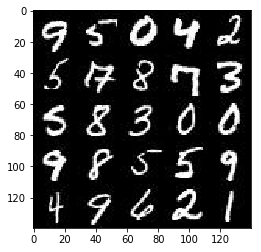

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

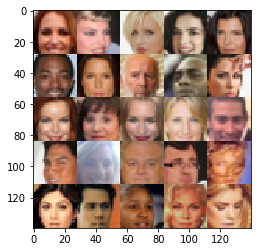

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer: 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.2 * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        # 4x4x256
        
        # Flatten the data
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    alpha = 0.2
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.2
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
import pickle as pkl
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Rescale image values from [-0.5, 0.5] to [-1, 1]
                batch_images *= 2.0
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print(
                        "Epoch {}/{}...".format(epoch_i, epoch_count),
                        "Discriminator Loss: {:.4f}...".format(train_loss_d),
                        "Generator Loss: {:.4f}".format(train_loss_g)
                    )
                    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(
                        sess=sess, 
                        n_images=25, 
                        input_z=input_z, 
                        out_channel_dim=image_channels, 
                        image_mode=data_image_mode
                    )
                    
    with open('samples.pkl', 'wb') as handle:
        pkl.dump(samples, handle)
    
    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.7709... Generator Loss: 1.3971
Epoch 0/2... Discriminator Loss: 0.7631... Generator Loss: 2.1791
Epoch 0/2... Discriminator Loss: 1.0595... Generator Loss: 2.0133
Epoch 0/2... Discriminator Loss: 0.8256... Generator Loss: 1.6188
Epoch 0/2... Discriminator Loss: 1.0527... Generator Loss: 1.0862
Epoch 0/2... Discriminator Loss: 1.0786... Generator Loss: 1.8074
Epoch 0/2... Discriminator Loss: 1.2398... Generator Loss: 0.6475
Epoch 0/2... Discriminator Loss: 0.8690... Generator Loss: 1.6019
Epoch 0/2... Discriminator Loss: 0.8367... Generator Loss: 1.5508
Epoch 0/2... Discriminator Loss: 0.9100... Generator Loss: 2.2472


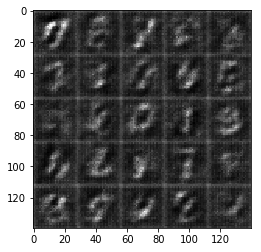

Epoch 0/2... Discriminator Loss: 1.1782... Generator Loss: 0.6944
Epoch 0/2... Discriminator Loss: 0.8858... Generator Loss: 1.8140
Epoch 0/2... Discriminator Loss: 0.8142... Generator Loss: 1.2922
Epoch 0/2... Discriminator Loss: 0.7644... Generator Loss: 1.8034
Epoch 0/2... Discriminator Loss: 0.9832... Generator Loss: 1.1634
Epoch 0/2... Discriminator Loss: 1.0574... Generator Loss: 0.7936
Epoch 0/2... Discriminator Loss: 1.2136... Generator Loss: 2.3892
Epoch 0/2... Discriminator Loss: 1.0265... Generator Loss: 2.2669
Epoch 0/2... Discriminator Loss: 1.2613... Generator Loss: 2.7760
Epoch 0/2... Discriminator Loss: 0.7518... Generator Loss: 1.5250


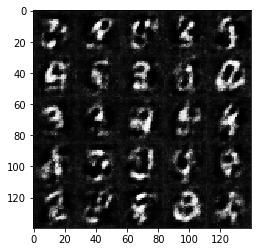

Epoch 0/2... Discriminator Loss: 0.8217... Generator Loss: 1.1538
Epoch 0/2... Discriminator Loss: 1.0671... Generator Loss: 0.7844
Epoch 0/2... Discriminator Loss: 0.6700... Generator Loss: 1.8497
Epoch 0/2... Discriminator Loss: 0.6882... Generator Loss: 1.8771
Epoch 0/2... Discriminator Loss: 0.8724... Generator Loss: 1.9037
Epoch 0/2... Discriminator Loss: 1.1185... Generator Loss: 0.7414
Epoch 0/2... Discriminator Loss: 1.1436... Generator Loss: 2.2570
Epoch 0/2... Discriminator Loss: 0.8365... Generator Loss: 1.1523
Epoch 0/2... Discriminator Loss: 0.7940... Generator Loss: 1.7259
Epoch 0/2... Discriminator Loss: 1.0883... Generator Loss: 0.7774


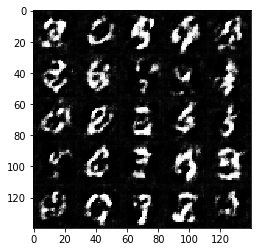

Epoch 0/2... Discriminator Loss: 0.7571... Generator Loss: 1.7031
Epoch 0/2... Discriminator Loss: 0.7920... Generator Loss: 1.2000
Epoch 0/2... Discriminator Loss: 0.7583... Generator Loss: 1.7184
Epoch 0/2... Discriminator Loss: 0.9221... Generator Loss: 1.0883
Epoch 0/2... Discriminator Loss: 0.8875... Generator Loss: 1.0852
Epoch 0/2... Discriminator Loss: 0.9186... Generator Loss: 1.0251
Epoch 0/2... Discriminator Loss: 0.7846... Generator Loss: 1.1471
Epoch 0/2... Discriminator Loss: 0.7483... Generator Loss: 1.9732
Epoch 0/2... Discriminator Loss: 0.9067... Generator Loss: 1.0077
Epoch 0/2... Discriminator Loss: 0.6721... Generator Loss: 2.6117


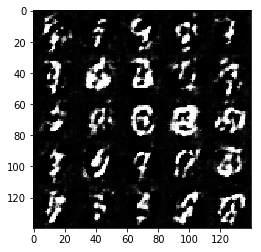

Epoch 0/2... Discriminator Loss: 0.7049... Generator Loss: 1.4784
Epoch 0/2... Discriminator Loss: 0.7074... Generator Loss: 1.4086
Epoch 0/2... Discriminator Loss: 0.9189... Generator Loss: 0.9713
Epoch 0/2... Discriminator Loss: 0.6165... Generator Loss: 2.0461
Epoch 0/2... Discriminator Loss: 1.0315... Generator Loss: 0.9391
Epoch 0/2... Discriminator Loss: 0.6521... Generator Loss: 1.5222
Epoch 0/2... Discriminator Loss: 0.6239... Generator Loss: 1.7286
Epoch 0/2... Discriminator Loss: 1.0194... Generator Loss: 0.9090
Epoch 0/2... Discriminator Loss: 1.4262... Generator Loss: 0.6322
Epoch 0/2... Discriminator Loss: 0.5644... Generator Loss: 2.1051


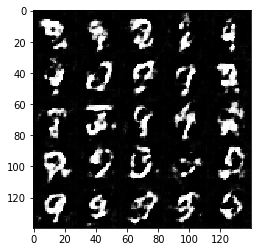

Epoch 0/2... Discriminator Loss: 0.8548... Generator Loss: 1.0884
Epoch 0/2... Discriminator Loss: 0.6035... Generator Loss: 1.7630
Epoch 0/2... Discriminator Loss: 0.6183... Generator Loss: 1.9105
Epoch 0/2... Discriminator Loss: 0.5880... Generator Loss: 2.1725
Epoch 0/2... Discriminator Loss: 1.3171... Generator Loss: 0.6333
Epoch 0/2... Discriminator Loss: 0.7117... Generator Loss: 1.3846
Epoch 0/2... Discriminator Loss: 0.6272... Generator Loss: 2.0865
Epoch 0/2... Discriminator Loss: 0.5886... Generator Loss: 1.8932
Epoch 0/2... Discriminator Loss: 0.6064... Generator Loss: 2.4197
Epoch 0/2... Discriminator Loss: 0.9917... Generator Loss: 0.8731


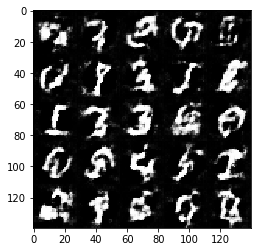

Epoch 0/2... Discriminator Loss: 0.8011... Generator Loss: 1.1470
Epoch 0/2... Discriminator Loss: 0.5974... Generator Loss: 2.0688
Epoch 0/2... Discriminator Loss: 0.6355... Generator Loss: 1.7909
Epoch 0/2... Discriminator Loss: 0.8540... Generator Loss: 1.1199
Epoch 0/2... Discriminator Loss: 0.6092... Generator Loss: 1.7740
Epoch 0/2... Discriminator Loss: 1.0747... Generator Loss: 0.8698
Epoch 0/2... Discriminator Loss: 0.8702... Generator Loss: 1.1155
Epoch 0/2... Discriminator Loss: 0.8606... Generator Loss: 1.1535
Epoch 0/2... Discriminator Loss: 0.8051... Generator Loss: 1.3620
Epoch 0/2... Discriminator Loss: 0.5979... Generator Loss: 1.8073


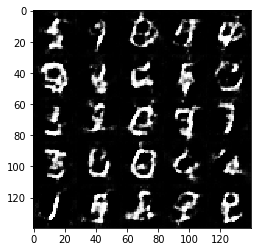

Epoch 0/2... Discriminator Loss: 0.6637... Generator Loss: 1.6629
Epoch 0/2... Discriminator Loss: 0.9906... Generator Loss: 0.8654
Epoch 0/2... Discriminator Loss: 1.1073... Generator Loss: 0.7310
Epoch 0/2... Discriminator Loss: 1.2892... Generator Loss: 0.5569
Epoch 0/2... Discriminator Loss: 0.7310... Generator Loss: 1.3427
Epoch 0/2... Discriminator Loss: 0.6822... Generator Loss: 1.9535
Epoch 0/2... Discriminator Loss: 0.6586... Generator Loss: 1.7874
Epoch 0/2... Discriminator Loss: 0.7999... Generator Loss: 1.2939
Epoch 0/2... Discriminator Loss: 1.4410... Generator Loss: 0.5060
Epoch 0/2... Discriminator Loss: 0.8625... Generator Loss: 1.0893


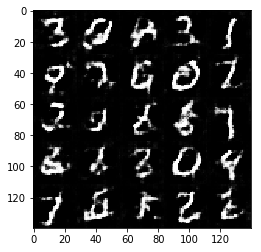

Epoch 0/2... Discriminator Loss: 1.0742... Generator Loss: 0.8024
Epoch 0/2... Discriminator Loss: 0.8143... Generator Loss: 1.1814
Epoch 0/2... Discriminator Loss: 0.9670... Generator Loss: 0.9044
Epoch 0/2... Discriminator Loss: 0.6778... Generator Loss: 1.9608
Epoch 0/2... Discriminator Loss: 1.0584... Generator Loss: 0.8366
Epoch 0/2... Discriminator Loss: 0.7419... Generator Loss: 1.8053
Epoch 0/2... Discriminator Loss: 0.8738... Generator Loss: 1.0217
Epoch 0/2... Discriminator Loss: 1.2558... Generator Loss: 0.6327
Epoch 0/2... Discriminator Loss: 0.8664... Generator Loss: 1.1628
Epoch 0/2... Discriminator Loss: 1.3462... Generator Loss: 0.5486


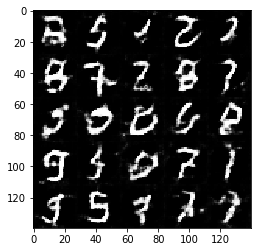

Epoch 0/2... Discriminator Loss: 0.9449... Generator Loss: 0.9570
Epoch 0/2... Discriminator Loss: 1.2131... Generator Loss: 0.6660
Epoch 0/2... Discriminator Loss: 0.7375... Generator Loss: 1.4463
Epoch 0/2... Discriminator Loss: 1.7802... Generator Loss: 0.3618
Epoch 0/2... Discriminator Loss: 1.0798... Generator Loss: 0.8396
Epoch 0/2... Discriminator Loss: 0.6735... Generator Loss: 2.0836
Epoch 0/2... Discriminator Loss: 0.7185... Generator Loss: 1.5199
Epoch 0/2... Discriminator Loss: 0.6903... Generator Loss: 2.1244
Epoch 0/2... Discriminator Loss: 0.6784... Generator Loss: 2.1231
Epoch 0/2... Discriminator Loss: 0.7973... Generator Loss: 1.3365


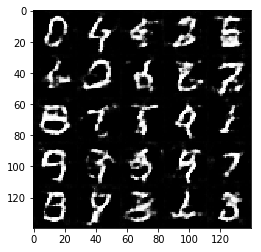

Epoch 0/2... Discriminator Loss: 0.7293... Generator Loss: 1.8163
Epoch 0/2... Discriminator Loss: 1.2970... Generator Loss: 0.5593
Epoch 0/2... Discriminator Loss: 0.7952... Generator Loss: 1.2798
Epoch 0/2... Discriminator Loss: 0.6038... Generator Loss: 1.9703
Epoch 0/2... Discriminator Loss: 0.7036... Generator Loss: 1.5506
Epoch 0/2... Discriminator Loss: 0.7350... Generator Loss: 2.0030
Epoch 0/2... Discriminator Loss: 0.6725... Generator Loss: 1.6598
Epoch 0/2... Discriminator Loss: 0.8226... Generator Loss: 1.1661
Epoch 0/2... Discriminator Loss: 1.0059... Generator Loss: 2.4268
Epoch 0/2... Discriminator Loss: 0.7488... Generator Loss: 1.2459


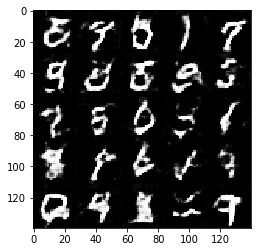

Epoch 0/2... Discriminator Loss: 0.6511... Generator Loss: 1.8604
Epoch 0/2... Discriminator Loss: 0.8207... Generator Loss: 1.1388
Epoch 0/2... Discriminator Loss: 0.8209... Generator Loss: 1.1262
Epoch 0/2... Discriminator Loss: 0.8854... Generator Loss: 1.0019
Epoch 0/2... Discriminator Loss: 0.6341... Generator Loss: 1.8650
Epoch 0/2... Discriminator Loss: 0.6340... Generator Loss: 1.6467
Epoch 0/2... Discriminator Loss: 0.8315... Generator Loss: 1.1572
Epoch 0/2... Discriminator Loss: 0.9793... Generator Loss: 0.9972
Epoch 0/2... Discriminator Loss: 1.0006... Generator Loss: 0.8778
Epoch 0/2... Discriminator Loss: 0.8843... Generator Loss: 0.9487


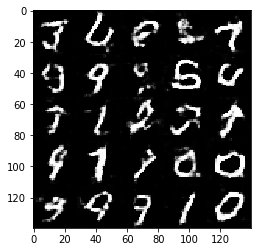

Epoch 0/2... Discriminator Loss: 0.8922... Generator Loss: 1.0420
Epoch 0/2... Discriminator Loss: 1.0071... Generator Loss: 0.9420
Epoch 0/2... Discriminator Loss: 0.5877... Generator Loss: 1.7075
Epoch 0/2... Discriminator Loss: 0.9646... Generator Loss: 0.8826
Epoch 0/2... Discriminator Loss: 1.0993... Generator Loss: 0.8208
Epoch 0/2... Discriminator Loss: 0.6332... Generator Loss: 1.5074
Epoch 0/2... Discriminator Loss: 1.0648... Generator Loss: 0.9425
Epoch 0/2... Discriminator Loss: 0.9955... Generator Loss: 0.8207
Epoch 0/2... Discriminator Loss: 0.8157... Generator Loss: 1.1761
Epoch 0/2... Discriminator Loss: 0.9215... Generator Loss: 0.9604


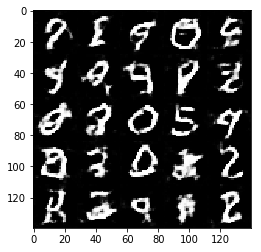

Epoch 0/2... Discriminator Loss: 5.5068... Generator Loss: 7.3349
Epoch 0/2... Discriminator Loss: 0.6798... Generator Loss: 1.9672
Epoch 0/2... Discriminator Loss: 0.4923... Generator Loss: 2.4444
Epoch 0/2... Discriminator Loss: 0.8006... Generator Loss: 1.1388
Epoch 0/2... Discriminator Loss: 0.7289... Generator Loss: 1.3579
Epoch 0/2... Discriminator Loss: 0.6933... Generator Loss: 1.5238
Epoch 0/2... Discriminator Loss: 0.8602... Generator Loss: 1.0227
Epoch 0/2... Discriminator Loss: 0.8063... Generator Loss: 1.3071
Epoch 0/2... Discriminator Loss: 0.7641... Generator Loss: 1.3171
Epoch 0/2... Discriminator Loss: 0.8721... Generator Loss: 1.0153


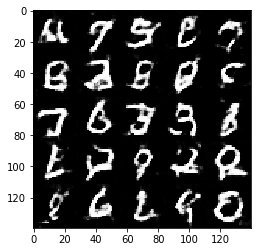

Epoch 0/2... Discriminator Loss: 0.5718... Generator Loss: 1.8203
Epoch 0/2... Discriminator Loss: 1.2876... Generator Loss: 0.5734
Epoch 0/2... Discriminator Loss: 0.7251... Generator Loss: 1.4640
Epoch 0/2... Discriminator Loss: 0.7266... Generator Loss: 1.3505
Epoch 0/2... Discriminator Loss: 0.8666... Generator Loss: 1.0487
Epoch 0/2... Discriminator Loss: 1.0372... Generator Loss: 0.9347
Epoch 0/2... Discriminator Loss: 0.9387... Generator Loss: 1.0095
Epoch 0/2... Discriminator Loss: 0.7316... Generator Loss: 1.2567
Epoch 0/2... Discriminator Loss: 0.5447... Generator Loss: 2.0150
Epoch 0/2... Discriminator Loss: 0.7605... Generator Loss: 1.4552


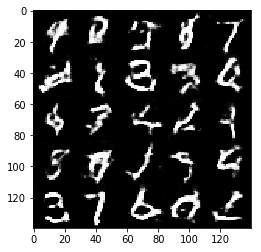

Epoch 0/2... Discriminator Loss: 1.6969... Generator Loss: 0.4216
Epoch 0/2... Discriminator Loss: 0.7407... Generator Loss: 1.3742
Epoch 0/2... Discriminator Loss: 0.9814... Generator Loss: 0.9319
Epoch 0/2... Discriminator Loss: 0.8371... Generator Loss: 1.0332
Epoch 0/2... Discriminator Loss: 0.8842... Generator Loss: 1.0214
Epoch 0/2... Discriminator Loss: 0.8332... Generator Loss: 1.1243
Epoch 0/2... Discriminator Loss: 0.6003... Generator Loss: 1.6510
Epoch 0/2... Discriminator Loss: 0.4898... Generator Loss: 2.1325
Epoch 0/2... Discriminator Loss: 1.1882... Generator Loss: 1.2137
Epoch 0/2... Discriminator Loss: 1.0364... Generator Loss: 0.8575


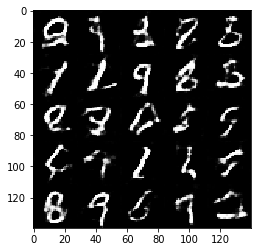

Epoch 0/2... Discriminator Loss: 0.9447... Generator Loss: 0.9521
Epoch 0/2... Discriminator Loss: 0.6991... Generator Loss: 1.4506
Epoch 0/2... Discriminator Loss: 0.8779... Generator Loss: 1.0831
Epoch 0/2... Discriminator Loss: 0.6464... Generator Loss: 1.6245
Epoch 0/2... Discriminator Loss: 0.8656... Generator Loss: 1.0641
Epoch 0/2... Discriminator Loss: 0.9862... Generator Loss: 0.8553
Epoch 0/2... Discriminator Loss: 1.0512... Generator Loss: 0.9586
Epoch 0/2... Discriminator Loss: 0.4951... Generator Loss: 2.5309
Epoch 0/2... Discriminator Loss: 0.7606... Generator Loss: 1.2332
Epoch 0/2... Discriminator Loss: 0.7064... Generator Loss: 1.3314


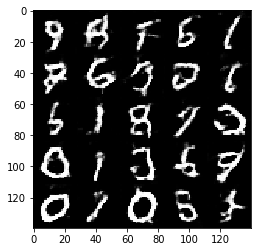

Epoch 0/2... Discriminator Loss: 0.7620... Generator Loss: 1.2004
Epoch 0/2... Discriminator Loss: 0.9107... Generator Loss: 1.0216
Epoch 0/2... Discriminator Loss: 0.6232... Generator Loss: 1.6894
Epoch 0/2... Discriminator Loss: 0.8528... Generator Loss: 3.2703
Epoch 0/2... Discriminator Loss: 0.7328... Generator Loss: 1.4770
Epoch 0/2... Discriminator Loss: 0.8363... Generator Loss: 1.0236
Epoch 0/2... Discriminator Loss: 0.6038... Generator Loss: 1.6544
Epoch 0/2... Discriminator Loss: 0.6389... Generator Loss: 1.4960
Epoch 0/2... Discriminator Loss: 0.7487... Generator Loss: 1.2489
Epoch 0/2... Discriminator Loss: 0.5535... Generator Loss: 1.8855


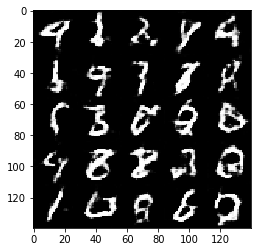

Epoch 0/2... Discriminator Loss: 0.7249... Generator Loss: 1.2683
Epoch 0/2... Discriminator Loss: 0.7201... Generator Loss: 1.2786
Epoch 0/2... Discriminator Loss: 0.7828... Generator Loss: 2.0105
Epoch 0/2... Discriminator Loss: 1.1802... Generator Loss: 0.7028
Epoch 0/2... Discriminator Loss: 0.6461... Generator Loss: 1.8710
Epoch 0/2... Discriminator Loss: 0.5329... Generator Loss: 2.0571
Epoch 0/2... Discriminator Loss: 0.5238... Generator Loss: 2.1139
Epoch 1/2... Discriminator Loss: 0.6749... Generator Loss: 1.8063
Epoch 1/2... Discriminator Loss: 0.9513... Generator Loss: 0.8709
Epoch 1/2... Discriminator Loss: 0.6459... Generator Loss: 1.5501
Epoch 1/2... Discriminator Loss: 0.6968... Generator Loss: 1.4105
Epoch 1/2... Discriminator Loss: 0.7122... Generator Loss: 1.3762
Epoch 1/2... Discriminator Loss: 0.6902... Generator Loss: 1.4529
Epoch 1/2... Discriminator Loss: 0.6242... Generator Loss: 1.7371
Epoch 1/2... Discriminator Loss: 0.6629... Generator Loss: 1.4458
Epoch 1/2.

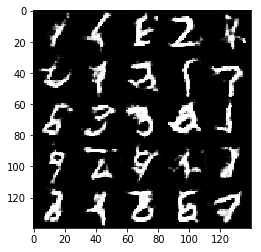

Epoch 1/2... Discriminator Loss: 0.6162... Generator Loss: 1.6417
Epoch 1/2... Discriminator Loss: 0.5264... Generator Loss: 1.9739
Epoch 1/2... Discriminator Loss: 0.6365... Generator Loss: 1.5759
Epoch 1/2... Discriminator Loss: 0.5156... Generator Loss: 2.3307
Epoch 1/2... Discriminator Loss: 0.7262... Generator Loss: 1.3352
Epoch 1/2... Discriminator Loss: 0.5460... Generator Loss: 2.2187
Epoch 1/2... Discriminator Loss: 0.5792... Generator Loss: 1.9849
Epoch 1/2... Discriminator Loss: 1.8684... Generator Loss: 0.6027
Epoch 1/2... Discriminator Loss: 0.4936... Generator Loss: 2.1329
Epoch 1/2... Discriminator Loss: 0.6061... Generator Loss: 1.5646


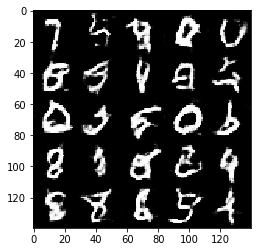

Epoch 1/2... Discriminator Loss: 0.6729... Generator Loss: 1.6286
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.5145
Epoch 1/2... Discriminator Loss: 0.5517... Generator Loss: 2.3119
Epoch 1/2... Discriminator Loss: 0.6064... Generator Loss: 1.6557
Epoch 1/2... Discriminator Loss: 0.5830... Generator Loss: 1.6928
Epoch 1/2... Discriminator Loss: 0.7206... Generator Loss: 1.3015
Epoch 1/2... Discriminator Loss: 0.8520... Generator Loss: 1.0994
Epoch 1/2... Discriminator Loss: 0.5860... Generator Loss: 1.6757
Epoch 1/2... Discriminator Loss: 0.5267... Generator Loss: 1.8996
Epoch 1/2... Discriminator Loss: 0.6009... Generator Loss: 1.7277


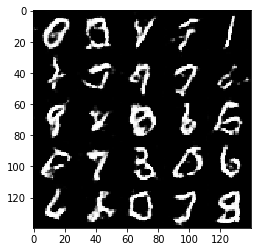

Epoch 1/2... Discriminator Loss: 0.5817... Generator Loss: 1.7719
Epoch 1/2... Discriminator Loss: 0.6313... Generator Loss: 1.6481
Epoch 1/2... Discriminator Loss: 0.7167... Generator Loss: 1.6603
Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 1.2156
Epoch 1/2... Discriminator Loss: 0.7860... Generator Loss: 2.5271
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 0.8199
Epoch 1/2... Discriminator Loss: 0.5201... Generator Loss: 2.0425
Epoch 1/2... Discriminator Loss: 0.7659... Generator Loss: 1.1876
Epoch 1/2... Discriminator Loss: 0.7285... Generator Loss: 1.2409
Epoch 1/2... Discriminator Loss: 0.6191... Generator Loss: 1.8145


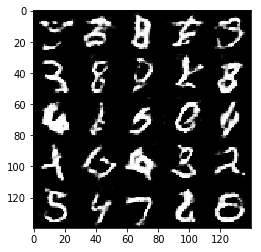

Epoch 1/2... Discriminator Loss: 0.5369... Generator Loss: 2.0553
Epoch 1/2... Discriminator Loss: 0.6067... Generator Loss: 1.7813
Epoch 1/2... Discriminator Loss: 0.7313... Generator Loss: 1.2830
Epoch 1/2... Discriminator Loss: 0.7100... Generator Loss: 1.3360
Epoch 1/2... Discriminator Loss: 0.6551... Generator Loss: 2.4000
Epoch 1/2... Discriminator Loss: 0.4629... Generator Loss: 2.4273
Epoch 1/2... Discriminator Loss: 1.2905... Generator Loss: 2.7413
Epoch 1/2... Discriminator Loss: 0.8927... Generator Loss: 1.1120
Epoch 1/2... Discriminator Loss: 0.5273... Generator Loss: 2.0247
Epoch 1/2... Discriminator Loss: 0.5504... Generator Loss: 1.8073


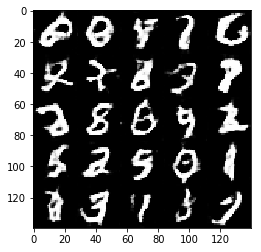

Epoch 1/2... Discriminator Loss: 0.6476... Generator Loss: 1.4631
Epoch 1/2... Discriminator Loss: 0.5313... Generator Loss: 2.0558
Epoch 1/2... Discriminator Loss: 0.4873... Generator Loss: 2.2078
Epoch 1/2... Discriminator Loss: 0.5981... Generator Loss: 1.7449
Epoch 1/2... Discriminator Loss: 0.5614... Generator Loss: 1.8041
Epoch 1/2... Discriminator Loss: 0.8053... Generator Loss: 1.1040
Epoch 1/2... Discriminator Loss: 0.6193... Generator Loss: 1.6447
Epoch 1/2... Discriminator Loss: 0.6636... Generator Loss: 1.4526
Epoch 1/2... Discriminator Loss: 0.6815... Generator Loss: 1.4262
Epoch 1/2... Discriminator Loss: 0.8930... Generator Loss: 0.9496


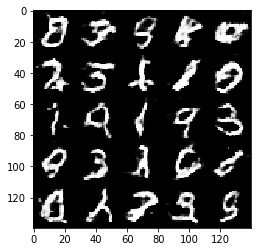

Epoch 1/2... Discriminator Loss: 0.7342... Generator Loss: 1.2760
Epoch 1/2... Discriminator Loss: 0.4886... Generator Loss: 2.1692
Epoch 1/2... Discriminator Loss: 0.4939... Generator Loss: 2.5022
Epoch 1/2... Discriminator Loss: 1.9479... Generator Loss: 0.3028
Epoch 1/2... Discriminator Loss: 2.2377... Generator Loss: 3.8937
Epoch 1/2... Discriminator Loss: 0.7068... Generator Loss: 1.5038
Epoch 1/2... Discriminator Loss: 0.7590... Generator Loss: 1.2821
Epoch 1/2... Discriminator Loss: 0.5111... Generator Loss: 1.9355
Epoch 1/2... Discriminator Loss: 0.8597... Generator Loss: 1.0880
Epoch 1/2... Discriminator Loss: 0.4640... Generator Loss: 2.4320


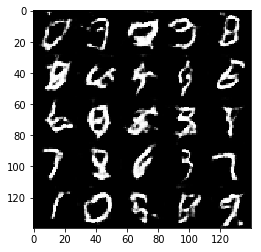

Epoch 1/2... Discriminator Loss: 0.6061... Generator Loss: 1.6458
Epoch 1/2... Discriminator Loss: 1.0422... Generator Loss: 0.9054
Epoch 1/2... Discriminator Loss: 0.6270... Generator Loss: 1.5238
Epoch 1/2... Discriminator Loss: 0.8877... Generator Loss: 0.9735
Epoch 1/2... Discriminator Loss: 0.7761... Generator Loss: 1.3105
Epoch 1/2... Discriminator Loss: 0.7226... Generator Loss: 1.4558
Epoch 1/2... Discriminator Loss: 0.5374... Generator Loss: 1.8501
Epoch 1/2... Discriminator Loss: 0.5654... Generator Loss: 1.7322
Epoch 1/2... Discriminator Loss: 0.4878... Generator Loss: 2.1033
Epoch 1/2... Discriminator Loss: 0.7375... Generator Loss: 1.2322


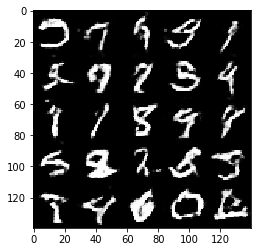

Epoch 1/2... Discriminator Loss: 0.9229... Generator Loss: 0.9312
Epoch 1/2... Discriminator Loss: 0.9566... Generator Loss: 1.0069
Epoch 1/2... Discriminator Loss: 0.7819... Generator Loss: 1.2007
Epoch 1/2... Discriminator Loss: 0.4586... Generator Loss: 2.3883
Epoch 1/2... Discriminator Loss: 0.5285... Generator Loss: 1.8774
Epoch 1/2... Discriminator Loss: 1.0553... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 0.6541... Generator Loss: 2.0874
Epoch 1/2... Discriminator Loss: 1.1095... Generator Loss: 0.8244
Epoch 1/2... Discriminator Loss: 0.4797... Generator Loss: 2.6445
Epoch 1/2... Discriminator Loss: 0.4950... Generator Loss: 2.1655


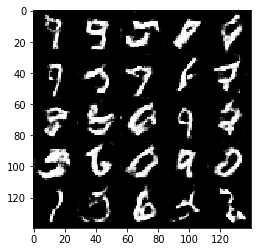

Epoch 1/2... Discriminator Loss: 0.9870... Generator Loss: 0.9898
Epoch 1/2... Discriminator Loss: 0.5666... Generator Loss: 1.8385
Epoch 1/2... Discriminator Loss: 0.7963... Generator Loss: 1.1311
Epoch 1/2... Discriminator Loss: 0.8473... Generator Loss: 1.1390
Epoch 1/2... Discriminator Loss: 0.6314... Generator Loss: 1.4881
Epoch 1/2... Discriminator Loss: 0.7618... Generator Loss: 1.2022
Epoch 1/2... Discriminator Loss: 0.6079... Generator Loss: 1.6528
Epoch 1/2... Discriminator Loss: 0.6923... Generator Loss: 1.3340
Epoch 1/2... Discriminator Loss: 0.4488... Generator Loss: 2.5355
Epoch 1/2... Discriminator Loss: 0.7005... Generator Loss: 1.4490


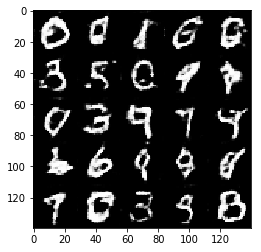

Epoch 1/2... Discriminator Loss: 0.6554... Generator Loss: 1.4810
Epoch 1/2... Discriminator Loss: 0.6023... Generator Loss: 1.5647
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 0.8579
Epoch 1/2... Discriminator Loss: 0.4808... Generator Loss: 2.2573
Epoch 1/2... Discriminator Loss: 0.5606... Generator Loss: 1.7971
Epoch 1/2... Discriminator Loss: 0.7337... Generator Loss: 1.2469
Epoch 1/2... Discriminator Loss: 0.6292... Generator Loss: 2.7269
Epoch 1/2... Discriminator Loss: 0.5604... Generator Loss: 1.8916
Epoch 1/2... Discriminator Loss: 0.6417... Generator Loss: 1.4665
Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 0.9433


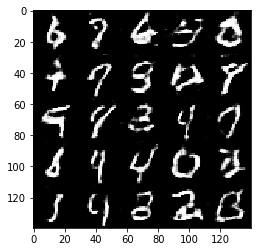

Epoch 1/2... Discriminator Loss: 0.6320... Generator Loss: 1.5883
Epoch 1/2... Discriminator Loss: 0.6386... Generator Loss: 1.4659
Epoch 1/2... Discriminator Loss: 0.6119... Generator Loss: 2.1138
Epoch 1/2... Discriminator Loss: 0.6016... Generator Loss: 2.8062
Epoch 1/2... Discriminator Loss: 0.8315... Generator Loss: 2.7596
Epoch 1/2... Discriminator Loss: 0.6252... Generator Loss: 1.7127
Epoch 1/2... Discriminator Loss: 0.6946... Generator Loss: 1.4252
Epoch 1/2... Discriminator Loss: 0.6820... Generator Loss: 1.4012
Epoch 1/2... Discriminator Loss: 1.0624... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 0.5345... Generator Loss: 1.8141


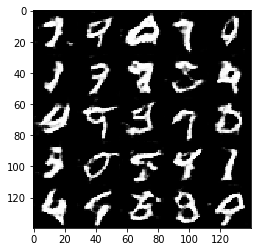

Epoch 1/2... Discriminator Loss: 0.5358... Generator Loss: 1.8504
Epoch 1/2... Discriminator Loss: 0.6555... Generator Loss: 1.4886
Epoch 1/2... Discriminator Loss: 0.6566... Generator Loss: 1.4925
Epoch 1/2... Discriminator Loss: 0.5558... Generator Loss: 1.7547
Epoch 1/2... Discriminator Loss: 0.6636... Generator Loss: 1.4417
Epoch 1/2... Discriminator Loss: 0.5638... Generator Loss: 1.8913
Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.6327
Epoch 1/2... Discriminator Loss: 0.8313... Generator Loss: 1.1548
Epoch 1/2... Discriminator Loss: 0.5739... Generator Loss: 1.7477
Epoch 1/2... Discriminator Loss: 0.6639... Generator Loss: 1.4326


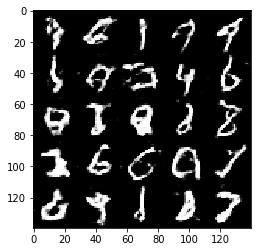

Epoch 1/2... Discriminator Loss: 0.5988... Generator Loss: 1.6076
Epoch 1/2... Discriminator Loss: 0.5643... Generator Loss: 1.7339
Epoch 1/2... Discriminator Loss: 0.4642... Generator Loss: 2.2574
Epoch 1/2... Discriminator Loss: 0.5970... Generator Loss: 1.6066
Epoch 1/2... Discriminator Loss: 0.6937... Generator Loss: 1.3314
Epoch 1/2... Discriminator Loss: 0.6496... Generator Loss: 1.4910
Epoch 1/2... Discriminator Loss: 0.7704... Generator Loss: 1.2500
Epoch 1/2... Discriminator Loss: 2.8370... Generator Loss: 0.1646
Epoch 1/2... Discriminator Loss: 0.6164... Generator Loss: 2.3458
Epoch 1/2... Discriminator Loss: 0.7386... Generator Loss: 1.3298


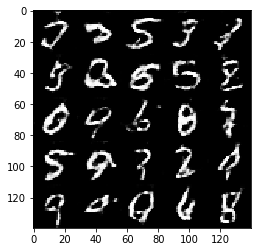

Epoch 1/2... Discriminator Loss: 0.6226... Generator Loss: 1.5568
Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 0.8549
Epoch 1/2... Discriminator Loss: 0.6257... Generator Loss: 1.6145
Epoch 1/2... Discriminator Loss: 0.5339... Generator Loss: 1.8959
Epoch 1/2... Discriminator Loss: 0.5855... Generator Loss: 1.8113
Epoch 1/2... Discriminator Loss: 0.5734... Generator Loss: 1.6689
Epoch 1/2... Discriminator Loss: 0.5111... Generator Loss: 1.9817
Epoch 1/2... Discriminator Loss: 1.5074... Generator Loss: 0.6096
Epoch 1/2... Discriminator Loss: 0.5361... Generator Loss: 2.1688
Epoch 1/2... Discriminator Loss: 0.7856... Generator Loss: 1.1432


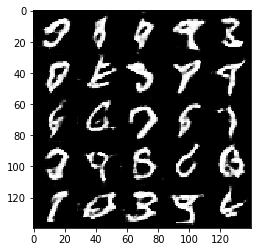

Epoch 1/2... Discriminator Loss: 0.7047... Generator Loss: 1.3040
Epoch 1/2... Discriminator Loss: 0.9929... Generator Loss: 0.8184
Epoch 1/2... Discriminator Loss: 0.8032... Generator Loss: 1.1634
Epoch 1/2... Discriminator Loss: 0.5699... Generator Loss: 1.8485
Epoch 1/2... Discriminator Loss: 1.3411... Generator Loss: 0.7599
Epoch 1/2... Discriminator Loss: 0.4880... Generator Loss: 2.6524
Epoch 1/2... Discriminator Loss: 0.7543... Generator Loss: 1.2461
Epoch 1/2... Discriminator Loss: 0.5495... Generator Loss: 1.9484
Epoch 1/2... Discriminator Loss: 1.5282... Generator Loss: 0.4908
Epoch 1/2... Discriminator Loss: 1.0258... Generator Loss: 0.8421


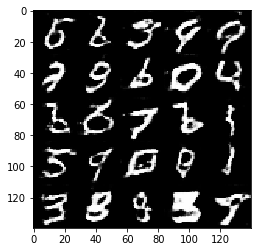

Epoch 1/2... Discriminator Loss: 0.7713... Generator Loss: 1.1592
Epoch 1/2... Discriminator Loss: 0.5796... Generator Loss: 1.8567
Epoch 1/2... Discriminator Loss: 0.5465... Generator Loss: 2.2866
Epoch 1/2... Discriminator Loss: 0.4328... Generator Loss: 2.7654
Epoch 1/2... Discriminator Loss: 1.0108... Generator Loss: 0.8578
Epoch 1/2... Discriminator Loss: 0.9385... Generator Loss: 1.0502
Epoch 1/2... Discriminator Loss: 0.4797... Generator Loss: 2.1926
Epoch 1/2... Discriminator Loss: 0.4939... Generator Loss: 2.2812
Epoch 1/2... Discriminator Loss: 0.4841... Generator Loss: 2.2104
Epoch 1/2... Discriminator Loss: 0.6952... Generator Loss: 1.3751


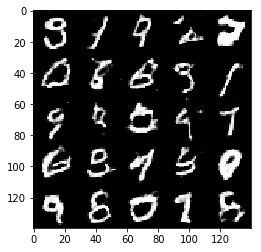

Epoch 1/2... Discriminator Loss: 0.4888... Generator Loss: 2.0933
Epoch 1/2... Discriminator Loss: 0.6740... Generator Loss: 1.5003
Epoch 1/2... Discriminator Loss: 0.5563... Generator Loss: 2.1887
Epoch 1/2... Discriminator Loss: 0.6578... Generator Loss: 1.4679
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 1.6083
Epoch 1/2... Discriminator Loss: 0.8388... Generator Loss: 1.1230
Epoch 1/2... Discriminator Loss: 1.0568... Generator Loss: 0.8066
Epoch 1/2... Discriminator Loss: 0.6738... Generator Loss: 1.4511
Epoch 1/2... Discriminator Loss: 0.6891... Generator Loss: 1.3644
Epoch 1/2... Discriminator Loss: 0.4250... Generator Loss: 3.0940


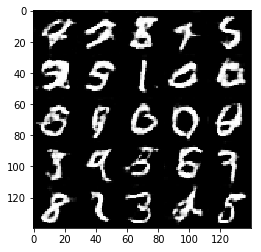

Epoch 1/2... Discriminator Loss: 0.7880... Generator Loss: 1.2912
Epoch 1/2... Discriminator Loss: 0.7954... Generator Loss: 1.0883
Epoch 1/2... Discriminator Loss: 0.9221... Generator Loss: 0.9963
Epoch 1/2... Discriminator Loss: 0.5787... Generator Loss: 1.6885
Epoch 1/2... Discriminator Loss: 0.6984... Generator Loss: 1.4483
Epoch 1/2... Discriminator Loss: 0.7350... Generator Loss: 1.3523
Epoch 1/2... Discriminator Loss: 0.6455... Generator Loss: 1.5357


In [19]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 1.0988... Generator Loss: 0.8985
Epoch 0/1... Discriminator Loss: 0.7562... Generator Loss: 1.4789
Epoch 0/1... Discriminator Loss: 0.7105... Generator Loss: 1.5782
Epoch 0/1... Discriminator Loss: 0.4886... Generator Loss: 2.4745
Epoch 0/1... Discriminator Loss: 0.5828... Generator Loss: 2.0696
Epoch 0/1... Discriminator Loss: 0.8645... Generator Loss: 1.1448
Epoch 0/1... Discriminator Loss: 1.8586... Generator Loss: 0.3361
Epoch 0/1... Discriminator Loss: 0.8711... Generator Loss: 1.1682
Epoch 0/1... Discriminator Loss: 1.3606... Generator Loss: 0.7721
Epoch 0/1... Discriminator Loss: 0.7760... Generator Loss: 1.8636


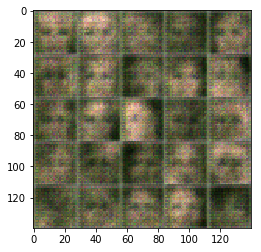

Epoch 0/1... Discriminator Loss: 0.7205... Generator Loss: 1.6898
Epoch 0/1... Discriminator Loss: 0.7381... Generator Loss: 1.6389
Epoch 0/1... Discriminator Loss: 0.7442... Generator Loss: 2.3425
Epoch 0/1... Discriminator Loss: 1.4580... Generator Loss: 0.5882
Epoch 0/1... Discriminator Loss: 0.9337... Generator Loss: 1.7717
Epoch 0/1... Discriminator Loss: 0.9560... Generator Loss: 1.1443
Epoch 0/1... Discriminator Loss: 1.2567... Generator Loss: 0.7164
Epoch 0/1... Discriminator Loss: 0.6934... Generator Loss: 2.5987
Epoch 0/1... Discriminator Loss: 1.0203... Generator Loss: 1.0195
Epoch 0/1... Discriminator Loss: 0.7841... Generator Loss: 1.6697


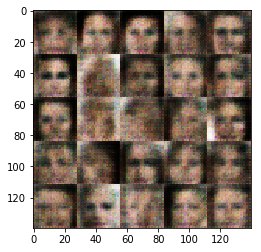

Epoch 0/1... Discriminator Loss: 1.5294... Generator Loss: 0.4428
Epoch 0/1... Discriminator Loss: 1.2873... Generator Loss: 1.9150
Epoch 0/1... Discriminator Loss: 1.0795... Generator Loss: 0.9720
Epoch 0/1... Discriminator Loss: 0.8594... Generator Loss: 1.3097
Epoch 0/1... Discriminator Loss: 1.1131... Generator Loss: 0.7677
Epoch 0/1... Discriminator Loss: 0.9345... Generator Loss: 1.0908
Epoch 0/1... Discriminator Loss: 0.9113... Generator Loss: 1.0560
Epoch 0/1... Discriminator Loss: 0.8549... Generator Loss: 1.2245
Epoch 0/1... Discriminator Loss: 0.7119... Generator Loss: 1.4503
Epoch 0/1... Discriminator Loss: 1.1358... Generator Loss: 0.7915


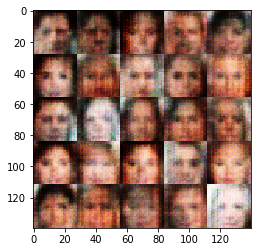

Epoch 0/1... Discriminator Loss: 1.0176... Generator Loss: 0.8476
Epoch 0/1... Discriminator Loss: 0.9997... Generator Loss: 1.3854
Epoch 0/1... Discriminator Loss: 0.8283... Generator Loss: 1.4238
Epoch 0/1... Discriminator Loss: 1.2126... Generator Loss: 0.7193
Epoch 0/1... Discriminator Loss: 0.7135... Generator Loss: 1.5374
Epoch 0/1... Discriminator Loss: 1.1275... Generator Loss: 1.9020
Epoch 0/1... Discriminator Loss: 1.2995... Generator Loss: 0.7565
Epoch 0/1... Discriminator Loss: 0.9169... Generator Loss: 1.0742
Epoch 0/1... Discriminator Loss: 0.7108... Generator Loss: 1.7399
Epoch 0/1... Discriminator Loss: 0.9699... Generator Loss: 0.9981


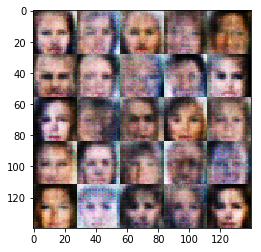

Epoch 0/1... Discriminator Loss: 1.2580... Generator Loss: 0.6241
Epoch 0/1... Discriminator Loss: 0.9038... Generator Loss: 1.3623
Epoch 0/1... Discriminator Loss: 1.2287... Generator Loss: 0.7263
Epoch 0/1... Discriminator Loss: 1.2290... Generator Loss: 0.5874
Epoch 0/1... Discriminator Loss: 0.9696... Generator Loss: 0.9111
Epoch 0/1... Discriminator Loss: 1.1002... Generator Loss: 0.7639
Epoch 0/1... Discriminator Loss: 0.9539... Generator Loss: 1.0646
Epoch 0/1... Discriminator Loss: 0.7708... Generator Loss: 1.6838
Epoch 0/1... Discriminator Loss: 0.7169... Generator Loss: 1.5915
Epoch 0/1... Discriminator Loss: 1.0246... Generator Loss: 1.7048


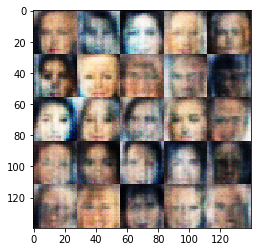

Epoch 0/1... Discriminator Loss: 1.5994... Generator Loss: 0.4268
Epoch 0/1... Discriminator Loss: 1.1190... Generator Loss: 1.3852
Epoch 0/1... Discriminator Loss: 1.2916... Generator Loss: 0.6207
Epoch 0/1... Discriminator Loss: 1.0626... Generator Loss: 1.0093
Epoch 0/1... Discriminator Loss: 1.0053... Generator Loss: 1.1333
Epoch 0/1... Discriminator Loss: 0.9846... Generator Loss: 0.9913
Epoch 0/1... Discriminator Loss: 0.9665... Generator Loss: 1.1642
Epoch 0/1... Discriminator Loss: 1.0657... Generator Loss: 0.9166
Epoch 0/1... Discriminator Loss: 0.8910... Generator Loss: 1.2933
Epoch 0/1... Discriminator Loss: 0.9166... Generator Loss: 1.4815


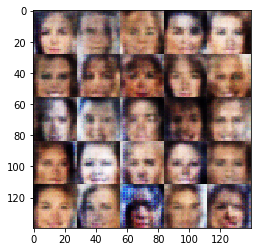

Epoch 0/1... Discriminator Loss: 0.9176... Generator Loss: 1.3206
Epoch 0/1... Discriminator Loss: 1.0435... Generator Loss: 0.8541
Epoch 0/1... Discriminator Loss: 0.9494... Generator Loss: 1.3513
Epoch 0/1... Discriminator Loss: 0.9744... Generator Loss: 1.2636
Epoch 0/1... Discriminator Loss: 1.1664... Generator Loss: 0.7318
Epoch 0/1... Discriminator Loss: 1.3800... Generator Loss: 0.5232
Epoch 0/1... Discriminator Loss: 1.0730... Generator Loss: 0.7734
Epoch 0/1... Discriminator Loss: 1.0320... Generator Loss: 1.3634
Epoch 0/1... Discriminator Loss: 1.0090... Generator Loss: 1.2657
Epoch 0/1... Discriminator Loss: 0.9032... Generator Loss: 1.1776


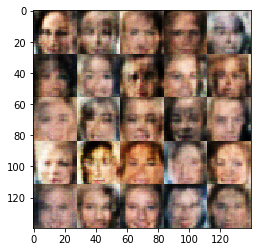

Epoch 0/1... Discriminator Loss: 0.9767... Generator Loss: 0.9479
Epoch 0/1... Discriminator Loss: 1.0420... Generator Loss: 1.3350
Epoch 0/1... Discriminator Loss: 1.0432... Generator Loss: 1.3219
Epoch 0/1... Discriminator Loss: 1.1376... Generator Loss: 0.8287
Epoch 0/1... Discriminator Loss: 0.9893... Generator Loss: 1.0768
Epoch 0/1... Discriminator Loss: 1.2228... Generator Loss: 2.0926
Epoch 0/1... Discriminator Loss: 1.3084... Generator Loss: 0.5792
Epoch 0/1... Discriminator Loss: 0.9575... Generator Loss: 1.2030
Epoch 0/1... Discriminator Loss: 0.9455... Generator Loss: 1.2519
Epoch 0/1... Discriminator Loss: 1.1293... Generator Loss: 0.7454


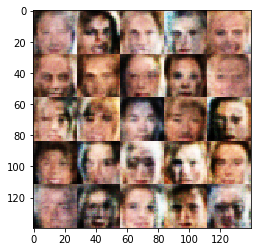

Epoch 0/1... Discriminator Loss: 0.9951... Generator Loss: 0.9678
Epoch 0/1... Discriminator Loss: 1.1647... Generator Loss: 0.7279
Epoch 0/1... Discriminator Loss: 1.0912... Generator Loss: 0.8112
Epoch 0/1... Discriminator Loss: 1.2102... Generator Loss: 1.0777
Epoch 0/1... Discriminator Loss: 0.9161... Generator Loss: 1.0897
Epoch 0/1... Discriminator Loss: 1.2173... Generator Loss: 1.8360
Epoch 0/1... Discriminator Loss: 1.2552... Generator Loss: 0.5617
Epoch 0/1... Discriminator Loss: 1.0236... Generator Loss: 1.0064
Epoch 0/1... Discriminator Loss: 1.1899... Generator Loss: 0.6580
Epoch 0/1... Discriminator Loss: 1.0224... Generator Loss: 1.1412


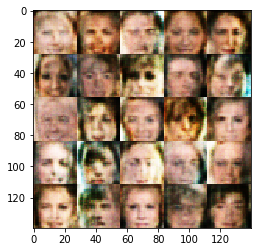

Epoch 0/1... Discriminator Loss: 1.1150... Generator Loss: 0.8436
Epoch 0/1... Discriminator Loss: 1.2964... Generator Loss: 0.6233
Epoch 0/1... Discriminator Loss: 1.1776... Generator Loss: 0.9763
Epoch 0/1... Discriminator Loss: 1.1894... Generator Loss: 0.6606
Epoch 0/1... Discriminator Loss: 1.0868... Generator Loss: 0.8050
Epoch 0/1... Discriminator Loss: 1.1635... Generator Loss: 0.7428
Epoch 0/1... Discriminator Loss: 1.1011... Generator Loss: 1.7540
Epoch 0/1... Discriminator Loss: 1.0037... Generator Loss: 0.9632
Epoch 0/1... Discriminator Loss: 0.9885... Generator Loss: 0.9456
Epoch 0/1... Discriminator Loss: 0.9965... Generator Loss: 0.9193


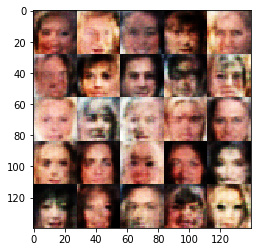

Epoch 0/1... Discriminator Loss: 1.0087... Generator Loss: 1.1030
Epoch 0/1... Discriminator Loss: 1.1882... Generator Loss: 0.9097
Epoch 0/1... Discriminator Loss: 1.3823... Generator Loss: 0.5325
Epoch 0/1... Discriminator Loss: 1.0230... Generator Loss: 0.9120
Epoch 0/1... Discriminator Loss: 0.8981... Generator Loss: 1.0249
Epoch 0/1... Discriminator Loss: 1.2503... Generator Loss: 0.6233
Epoch 0/1... Discriminator Loss: 0.9869... Generator Loss: 1.1810
Epoch 0/1... Discriminator Loss: 1.2604... Generator Loss: 0.6001
Epoch 0/1... Discriminator Loss: 1.2045... Generator Loss: 0.6630
Epoch 0/1... Discriminator Loss: 0.9700... Generator Loss: 1.3297


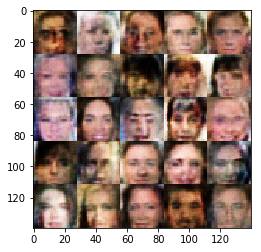

Epoch 0/1... Discriminator Loss: 1.3304... Generator Loss: 0.6287
Epoch 0/1... Discriminator Loss: 1.1876... Generator Loss: 0.7303
Epoch 0/1... Discriminator Loss: 0.9346... Generator Loss: 1.2697
Epoch 0/1... Discriminator Loss: 1.0515... Generator Loss: 0.7995
Epoch 0/1... Discriminator Loss: 1.0989... Generator Loss: 0.9186
Epoch 0/1... Discriminator Loss: 0.8920... Generator Loss: 1.2040
Epoch 0/1... Discriminator Loss: 1.3404... Generator Loss: 0.5347
Epoch 0/1... Discriminator Loss: 0.9642... Generator Loss: 1.1850
Epoch 0/1... Discriminator Loss: 1.1497... Generator Loss: 0.7496
Epoch 0/1... Discriminator Loss: 1.1318... Generator Loss: 0.7743


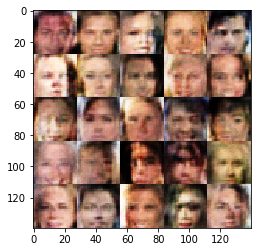

Epoch 0/1... Discriminator Loss: 1.0994... Generator Loss: 0.8090
Epoch 0/1... Discriminator Loss: 0.9364... Generator Loss: 1.2071
Epoch 0/1... Discriminator Loss: 1.5723... Generator Loss: 0.3958
Epoch 0/1... Discriminator Loss: 1.0904... Generator Loss: 0.8070
Epoch 0/1... Discriminator Loss: 0.8620... Generator Loss: 1.4816
Epoch 0/1... Discriminator Loss: 0.7416... Generator Loss: 1.8068
Epoch 0/1... Discriminator Loss: 1.1394... Generator Loss: 2.0323
Epoch 0/1... Discriminator Loss: 1.1423... Generator Loss: 0.6944
Epoch 0/1... Discriminator Loss: 1.5833... Generator Loss: 0.3880
Epoch 0/1... Discriminator Loss: 0.7857... Generator Loss: 1.5238


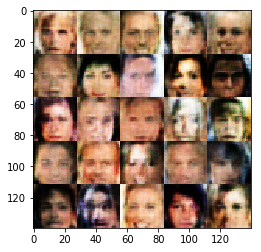

Epoch 0/1... Discriminator Loss: 0.8422... Generator Loss: 1.6409
Epoch 0/1... Discriminator Loss: 0.9203... Generator Loss: 1.0107
Epoch 0/1... Discriminator Loss: 0.8213... Generator Loss: 1.4574
Epoch 0/1... Discriminator Loss: 1.0235... Generator Loss: 0.8325
Epoch 0/1... Discriminator Loss: 1.7543... Generator Loss: 0.3262
Epoch 0/1... Discriminator Loss: 1.1558... Generator Loss: 1.1971
Epoch 0/1... Discriminator Loss: 0.9093... Generator Loss: 1.4339
Epoch 0/1... Discriminator Loss: 1.2282... Generator Loss: 0.6274
Epoch 0/1... Discriminator Loss: 0.9605... Generator Loss: 0.9657
Epoch 0/1... Discriminator Loss: 0.8478... Generator Loss: 1.3812


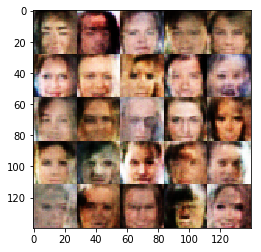

Epoch 0/1... Discriminator Loss: 1.3079... Generator Loss: 0.6119
Epoch 0/1... Discriminator Loss: 1.0805... Generator Loss: 1.0038
Epoch 0/1... Discriminator Loss: 1.2771... Generator Loss: 0.6159
Epoch 0/1... Discriminator Loss: 0.9846... Generator Loss: 1.6709
Epoch 0/1... Discriminator Loss: 0.8841... Generator Loss: 1.0951
Epoch 0/1... Discriminator Loss: 1.2432... Generator Loss: 0.6089
Epoch 0/1... Discriminator Loss: 0.9545... Generator Loss: 1.1205
Epoch 0/1... Discriminator Loss: 1.0880... Generator Loss: 0.7151
Epoch 0/1... Discriminator Loss: 1.1916... Generator Loss: 0.7547
Epoch 0/1... Discriminator Loss: 1.0435... Generator Loss: 1.6669


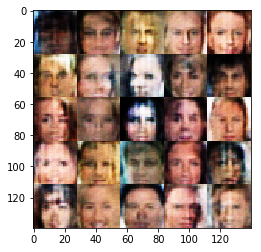

Epoch 0/1... Discriminator Loss: 0.9970... Generator Loss: 0.8564
Epoch 0/1... Discriminator Loss: 0.7197... Generator Loss: 1.9426
Epoch 0/1... Discriminator Loss: 1.2597... Generator Loss: 0.6215
Epoch 0/1... Discriminator Loss: 0.9051... Generator Loss: 1.0769
Epoch 0/1... Discriminator Loss: 0.8024... Generator Loss: 1.3413
Epoch 0/1... Discriminator Loss: 0.7039... Generator Loss: 2.1726
Epoch 0/1... Discriminator Loss: 1.3272... Generator Loss: 0.5990
Epoch 0/1... Discriminator Loss: 0.9925... Generator Loss: 0.8923
Epoch 0/1... Discriminator Loss: 1.6093... Generator Loss: 0.3772
Epoch 0/1... Discriminator Loss: 1.1137... Generator Loss: 0.7506


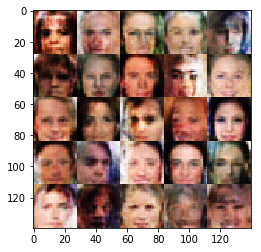

Epoch 0/1... Discriminator Loss: 1.1974... Generator Loss: 0.8017
Epoch 0/1... Discriminator Loss: 0.9447... Generator Loss: 1.2014
Epoch 0/1... Discriminator Loss: 0.9746... Generator Loss: 0.8847
Epoch 0/1... Discriminator Loss: 0.7391... Generator Loss: 1.2880
Epoch 0/1... Discriminator Loss: 1.3021... Generator Loss: 3.0550
Epoch 0/1... Discriminator Loss: 1.1891... Generator Loss: 0.6875
Epoch 0/1... Discriminator Loss: 0.8215... Generator Loss: 1.0766
Epoch 0/1... Discriminator Loss: 0.9221... Generator Loss: 1.3396
Epoch 0/1... Discriminator Loss: 1.1790... Generator Loss: 1.1954
Epoch 0/1... Discriminator Loss: 1.0355... Generator Loss: 0.9039


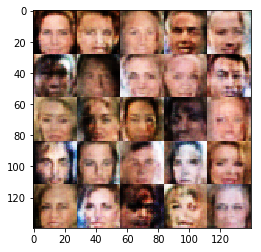

Epoch 0/1... Discriminator Loss: 0.8991... Generator Loss: 1.8014
Epoch 0/1... Discriminator Loss: 1.6089... Generator Loss: 0.3869
Epoch 0/1... Discriminator Loss: 1.4687... Generator Loss: 0.4382
Epoch 0/1... Discriminator Loss: 0.8290... Generator Loss: 1.1807
Epoch 0/1... Discriminator Loss: 0.7476... Generator Loss: 1.2923
Epoch 0/1... Discriminator Loss: 1.1253... Generator Loss: 0.9198
Epoch 0/1... Discriminator Loss: 1.0096... Generator Loss: 0.9544
Epoch 0/1... Discriminator Loss: 1.0350... Generator Loss: 0.8368
Epoch 0/1... Discriminator Loss: 1.0122... Generator Loss: 0.9698
Epoch 0/1... Discriminator Loss: 0.7569... Generator Loss: 1.4305


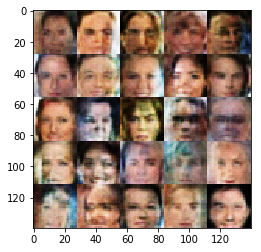

Epoch 0/1... Discriminator Loss: 0.7915... Generator Loss: 1.4903
Epoch 0/1... Discriminator Loss: 1.4160... Generator Loss: 0.4534
Epoch 0/1... Discriminator Loss: 1.2059... Generator Loss: 1.8832
Epoch 0/1... Discriminator Loss: 0.8573... Generator Loss: 1.4054
Epoch 0/1... Discriminator Loss: 0.7971... Generator Loss: 1.2603
Epoch 0/1... Discriminator Loss: 1.2021... Generator Loss: 0.6729
Epoch 0/1... Discriminator Loss: 1.0580... Generator Loss: 0.8208
Epoch 0/1... Discriminator Loss: 1.2680... Generator Loss: 0.5811
Epoch 0/1... Discriminator Loss: 0.7669... Generator Loss: 1.7000
Epoch 0/1... Discriminator Loss: 0.8877... Generator Loss: 1.4789


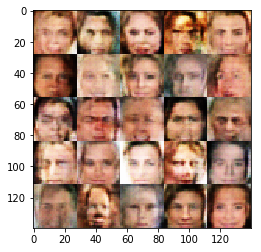

Epoch 0/1... Discriminator Loss: 1.0900... Generator Loss: 0.8116
Epoch 0/1... Discriminator Loss: 1.2249... Generator Loss: 0.6375
Epoch 0/1... Discriminator Loss: 1.0885... Generator Loss: 0.8443
Epoch 0/1... Discriminator Loss: 1.0215... Generator Loss: 0.9708
Epoch 0/1... Discriminator Loss: 1.2237... Generator Loss: 0.6449
Epoch 0/1... Discriminator Loss: 0.9955... Generator Loss: 1.2529
Epoch 0/1... Discriminator Loss: 0.8957... Generator Loss: 2.1119
Epoch 0/1... Discriminator Loss: 0.8039... Generator Loss: 1.2455
Epoch 0/1... Discriminator Loss: 1.4763... Generator Loss: 0.4491
Epoch 0/1... Discriminator Loss: 1.0333... Generator Loss: 0.8728


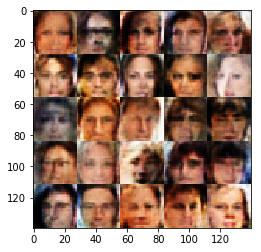

Epoch 0/1... Discriminator Loss: 1.6527... Generator Loss: 0.3530
Epoch 0/1... Discriminator Loss: 1.0015... Generator Loss: 0.8844
Epoch 0/1... Discriminator Loss: 1.1920... Generator Loss: 0.6641
Epoch 0/1... Discriminator Loss: 0.8199... Generator Loss: 1.2456
Epoch 0/1... Discriminator Loss: 0.7271... Generator Loss: 1.3488
Epoch 0/1... Discriminator Loss: 0.9347... Generator Loss: 1.0773
Epoch 0/1... Discriminator Loss: 0.7748... Generator Loss: 1.4094
Epoch 0/1... Discriminator Loss: 0.8793... Generator Loss: 1.3060
Epoch 0/1... Discriminator Loss: 0.9391... Generator Loss: 1.0197
Epoch 0/1... Discriminator Loss: 1.0214... Generator Loss: 0.9494


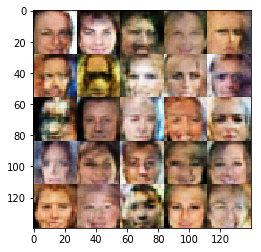

Epoch 0/1... Discriminator Loss: 1.0090... Generator Loss: 1.2563
Epoch 0/1... Discriminator Loss: 1.4928... Generator Loss: 0.4233
Epoch 0/1... Discriminator Loss: 0.7684... Generator Loss: 1.3934
Epoch 0/1... Discriminator Loss: 0.8355... Generator Loss: 1.0602
Epoch 0/1... Discriminator Loss: 1.2306... Generator Loss: 0.6431
Epoch 0/1... Discriminator Loss: 1.3175... Generator Loss: 0.5282
Epoch 0/1... Discriminator Loss: 1.2840... Generator Loss: 0.5581
Epoch 0/1... Discriminator Loss: 0.7773... Generator Loss: 1.2169
Epoch 0/1... Discriminator Loss: 1.6226... Generator Loss: 0.3660
Epoch 0/1... Discriminator Loss: 0.8887... Generator Loss: 1.1811


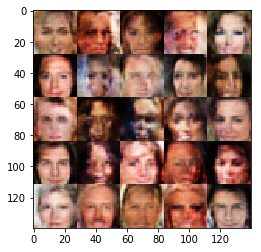

Epoch 0/1... Discriminator Loss: 0.8203... Generator Loss: 1.4367
Epoch 0/1... Discriminator Loss: 0.8945... Generator Loss: 0.9965
Epoch 0/1... Discriminator Loss: 0.7547... Generator Loss: 1.2837
Epoch 0/1... Discriminator Loss: 1.1134... Generator Loss: 0.6965
Epoch 0/1... Discriminator Loss: 0.7155... Generator Loss: 2.0686
Epoch 0/1... Discriminator Loss: 0.8612... Generator Loss: 1.0809
Epoch 0/1... Discriminator Loss: 0.9690... Generator Loss: 0.8766
Epoch 0/1... Discriminator Loss: 0.8390... Generator Loss: 1.2220
Epoch 0/1... Discriminator Loss: 0.8856... Generator Loss: 1.4130
Epoch 0/1... Discriminator Loss: 1.1906... Generator Loss: 0.6547


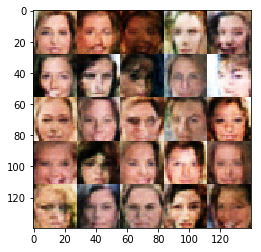

Epoch 0/1... Discriminator Loss: 1.1012... Generator Loss: 0.9591
Epoch 0/1... Discriminator Loss: 1.1242... Generator Loss: 1.7285
Epoch 0/1... Discriminator Loss: 0.9204... Generator Loss: 1.0053
Epoch 0/1... Discriminator Loss: 1.4243... Generator Loss: 0.4885
Epoch 0/1... Discriminator Loss: 1.2042... Generator Loss: 0.6203
Epoch 0/1... Discriminator Loss: 1.3289... Generator Loss: 1.0459
Epoch 0/1... Discriminator Loss: 0.7444... Generator Loss: 1.4324
Epoch 0/1... Discriminator Loss: 1.0686... Generator Loss: 0.7494
Epoch 0/1... Discriminator Loss: 0.9470... Generator Loss: 0.9624
Epoch 0/1... Discriminator Loss: 0.9497... Generator Loss: 1.1350


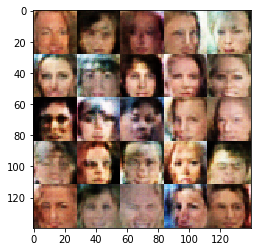

Epoch 0/1... Discriminator Loss: 0.9483... Generator Loss: 1.0496
Epoch 0/1... Discriminator Loss: 0.9669... Generator Loss: 0.9551
Epoch 0/1... Discriminator Loss: 0.8124... Generator Loss: 1.4444
Epoch 0/1... Discriminator Loss: 1.2871... Generator Loss: 0.5451
Epoch 0/1... Discriminator Loss: 1.5000... Generator Loss: 0.4308
Epoch 0/1... Discriminator Loss: 0.9297... Generator Loss: 1.0186
Epoch 0/1... Discriminator Loss: 0.9649... Generator Loss: 0.9280
Epoch 0/1... Discriminator Loss: 0.9662... Generator Loss: 1.1860
Epoch 0/1... Discriminator Loss: 1.2452... Generator Loss: 0.6007
Epoch 0/1... Discriminator Loss: 0.8279... Generator Loss: 1.3389


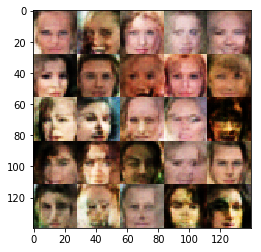

Epoch 0/1... Discriminator Loss: 0.8677... Generator Loss: 1.1442
Epoch 0/1... Discriminator Loss: 0.9456... Generator Loss: 1.0273
Epoch 0/1... Discriminator Loss: 0.7907... Generator Loss: 1.1502
Epoch 0/1... Discriminator Loss: 0.7441... Generator Loss: 1.4187
Epoch 0/1... Discriminator Loss: 1.5549... Generator Loss: 0.4198
Epoch 0/1... Discriminator Loss: 1.0375... Generator Loss: 0.9418
Epoch 0/1... Discriminator Loss: 1.4557... Generator Loss: 0.4718
Epoch 0/1... Discriminator Loss: 0.8817... Generator Loss: 1.0216
Epoch 0/1... Discriminator Loss: 0.9010... Generator Loss: 1.2897
Epoch 0/1... Discriminator Loss: 0.7759... Generator Loss: 1.3570


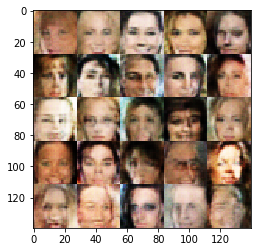

Epoch 0/1... Discriminator Loss: 0.6118... Generator Loss: 1.7018
Epoch 0/1... Discriminator Loss: 0.9268... Generator Loss: 1.1729
Epoch 0/1... Discriminator Loss: 0.9636... Generator Loss: 0.9215
Epoch 0/1... Discriminator Loss: 0.9008... Generator Loss: 0.9178
Epoch 0/1... Discriminator Loss: 1.0976... Generator Loss: 2.6109
Epoch 0/1... Discriminator Loss: 1.0854... Generator Loss: 0.9347
Epoch 0/1... Discriminator Loss: 0.9368... Generator Loss: 0.8894
Epoch 0/1... Discriminator Loss: 1.2202... Generator Loss: 0.6269
Epoch 0/1... Discriminator Loss: 1.1746... Generator Loss: 0.6920
Epoch 0/1... Discriminator Loss: 1.5317... Generator Loss: 0.4150


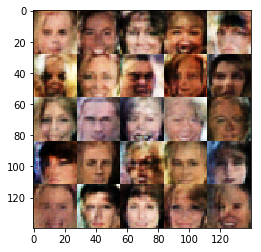

Epoch 0/1... Discriminator Loss: 0.9894... Generator Loss: 0.9549
Epoch 0/1... Discriminator Loss: 1.1179... Generator Loss: 0.7377
Epoch 0/1... Discriminator Loss: 0.8410... Generator Loss: 1.1979
Epoch 0/1... Discriminator Loss: 1.7797... Generator Loss: 0.3414
Epoch 0/1... Discriminator Loss: 0.8532... Generator Loss: 1.0492
Epoch 0/1... Discriminator Loss: 1.3398... Generator Loss: 0.5302
Epoch 0/1... Discriminator Loss: 1.0362... Generator Loss: 0.8603
Epoch 0/1... Discriminator Loss: 0.8782... Generator Loss: 2.0159
Epoch 0/1... Discriminator Loss: 1.0011... Generator Loss: 0.8992
Epoch 0/1... Discriminator Loss: 0.7741... Generator Loss: 1.2593


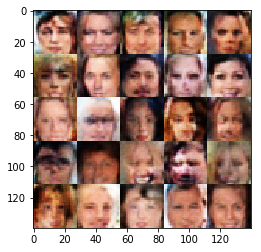

Epoch 0/1... Discriminator Loss: 0.6467... Generator Loss: 1.6356
Epoch 0/1... Discriminator Loss: 0.7187... Generator Loss: 1.2648
Epoch 0/1... Discriminator Loss: 0.7575... Generator Loss: 1.3805
Epoch 0/1... Discriminator Loss: 0.8510... Generator Loss: 1.1306
Epoch 0/1... Discriminator Loss: 0.8409... Generator Loss: 1.0051
Epoch 0/1... Discriminator Loss: 0.6126... Generator Loss: 1.9281
Epoch 0/1... Discriminator Loss: 1.0545... Generator Loss: 2.6509
Epoch 0/1... Discriminator Loss: 0.8651... Generator Loss: 1.0237
Epoch 0/1... Discriminator Loss: 0.9469... Generator Loss: 0.8796
Epoch 0/1... Discriminator Loss: 1.0026... Generator Loss: 0.8175


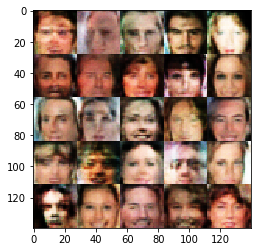

Epoch 0/1... Discriminator Loss: 0.8786... Generator Loss: 0.9839
Epoch 0/1... Discriminator Loss: 1.6153... Generator Loss: 0.4284
Epoch 0/1... Discriminator Loss: 0.8397... Generator Loss: 1.1092
Epoch 0/1... Discriminator Loss: 0.7587... Generator Loss: 1.1846
Epoch 0/1... Discriminator Loss: 0.4084... Generator Loss: 2.9506
Epoch 0/1... Discriminator Loss: 0.4332... Generator Loss: 3.0115
Epoch 0/1... Discriminator Loss: 0.6208... Generator Loss: 1.5388
Epoch 0/1... Discriminator Loss: 0.4745... Generator Loss: 2.4327
Epoch 0/1... Discriminator Loss: 1.0675... Generator Loss: 0.8002
Epoch 0/1... Discriminator Loss: 0.7239... Generator Loss: 1.3956


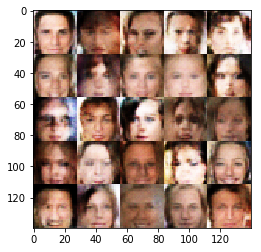

Epoch 0/1... Discriminator Loss: 0.7001... Generator Loss: 1.4102
Epoch 0/1... Discriminator Loss: 0.4841... Generator Loss: 2.5516
Epoch 0/1... Discriminator Loss: 0.4298... Generator Loss: 3.6250
Epoch 0/1... Discriminator Loss: 0.5012... Generator Loss: 3.7785
Epoch 0/1... Discriminator Loss: 1.0025... Generator Loss: 0.7823
Epoch 0/1... Discriminator Loss: 0.4488... Generator Loss: 2.5212
Epoch 0/1... Discriminator Loss: 0.9964... Generator Loss: 0.8430
Epoch 0/1... Discriminator Loss: 2.2990... Generator Loss: 0.2000
Epoch 0/1... Discriminator Loss: 0.9240... Generator Loss: 5.0780
Epoch 0/1... Discriminator Loss: 0.5018... Generator Loss: 2.2910


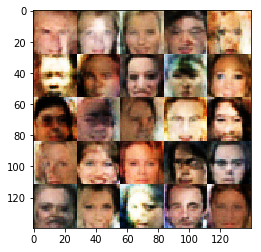

Epoch 0/1... Discriminator Loss: 0.9293... Generator Loss: 1.1015
Epoch 0/1... Discriminator Loss: 0.5077... Generator Loss: 2.2195
Epoch 0/1... Discriminator Loss: 0.5104... Generator Loss: 2.2187
Epoch 0/1... Discriminator Loss: 0.4913... Generator Loss: 2.2158
Epoch 0/1... Discriminator Loss: 0.8381... Generator Loss: 1.0324
Epoch 0/1... Discriminator Loss: 0.3927... Generator Loss: 3.4832
Epoch 0/1... Discriminator Loss: 0.8367... Generator Loss: 1.0887
Epoch 0/1... Discriminator Loss: 0.7837... Generator Loss: 1.1423
Epoch 0/1... Discriminator Loss: 0.3538... Generator Loss: 4.8309
Epoch 0/1... Discriminator Loss: 0.4470... Generator Loss: 2.5376


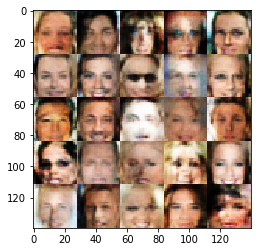

Epoch 0/1... Discriminator Loss: 0.3428... Generator Loss: 5.0197
Epoch 0/1... Discriminator Loss: 1.0741... Generator Loss: 0.7990
Epoch 0/1... Discriminator Loss: 0.6361... Generator Loss: 1.5207
Epoch 0/1... Discriminator Loss: 0.4207... Generator Loss: 2.7455
Epoch 0/1... Discriminator Loss: 0.4215... Generator Loss: 2.9320
Epoch 0/1... Discriminator Loss: 0.5891... Generator Loss: 2.5708
Epoch 0/1... Discriminator Loss: 1.1026... Generator Loss: 1.3419
Epoch 0/1... Discriminator Loss: 0.3674... Generator Loss: 3.7044
Epoch 0/1... Discriminator Loss: 0.5948... Generator Loss: 4.4192
Epoch 0/1... Discriminator Loss: 0.3416... Generator Loss: 6.1588


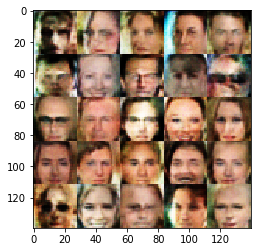

Epoch 0/1... Discriminator Loss: 0.4257... Generator Loss: 4.2866
Epoch 0/1... Discriminator Loss: 0.5545... Generator Loss: 4.2464
Epoch 0/1... Discriminator Loss: 0.4233... Generator Loss: 2.9204
Epoch 0/1... Discriminator Loss: 0.3954... Generator Loss: 3.8635
Epoch 0/1... Discriminator Loss: 0.5287... Generator Loss: 4.6206
Epoch 0/1... Discriminator Loss: 0.7788... Generator Loss: 4.7300
Epoch 0/1... Discriminator Loss: 1.0496... Generator Loss: 0.7568
Epoch 0/1... Discriminator Loss: 0.6316... Generator Loss: 1.5340
Epoch 0/1... Discriminator Loss: 1.3023... Generator Loss: 0.6364
Epoch 0/1... Discriminator Loss: 0.3906... Generator Loss: 3.1458


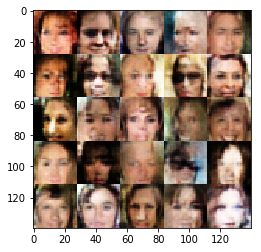

Epoch 0/1... Discriminator Loss: 0.3978... Generator Loss: 3.3681
Epoch 0/1... Discriminator Loss: 0.8319... Generator Loss: 1.1293
Epoch 0/1... Discriminator Loss: 0.5506... Generator Loss: 1.7889
Epoch 0/1... Discriminator Loss: 0.3860... Generator Loss: 3.2685
Epoch 0/1... Discriminator Loss: 0.6683... Generator Loss: 1.4619
Epoch 0/1... Discriminator Loss: 0.5303... Generator Loss: 2.1577
Epoch 0/1... Discriminator Loss: 0.3601... Generator Loss: 4.4148
Epoch 0/1... Discriminator Loss: 0.4014... Generator Loss: 6.6488
Epoch 0/1... Discriminator Loss: 0.3598... Generator Loss: 4.8511
Epoch 0/1... Discriminator Loss: 0.4401... Generator Loss: 4.5795


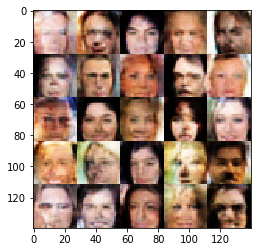

Epoch 0/1... Discriminator Loss: 0.5614... Generator Loss: 1.8752
Epoch 0/1... Discriminator Loss: 0.3550... Generator Loss: 4.3292
Epoch 0/1... Discriminator Loss: 0.4800... Generator Loss: 2.4249
Epoch 0/1... Discriminator Loss: 0.7221... Generator Loss: 1.4758
Epoch 0/1... Discriminator Loss: 0.7079... Generator Loss: 3.9317
Epoch 0/1... Discriminator Loss: 0.3544... Generator Loss: 4.5056
Epoch 0/1... Discriminator Loss: 0.4351... Generator Loss: 2.5617
Epoch 0/1... Discriminator Loss: 0.3477... Generator Loss: 4.9976
Epoch 0/1... Discriminator Loss: 0.4222... Generator Loss: 2.8305
Epoch 0/1... Discriminator Loss: 0.7706... Generator Loss: 1.2145


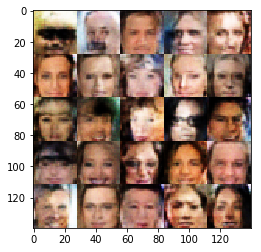

Epoch 0/1... Discriminator Loss: 0.3725... Generator Loss: 3.7811
Epoch 0/1... Discriminator Loss: 0.5017... Generator Loss: 2.5997
Epoch 0/1... Discriminator Loss: 0.4766... Generator Loss: 2.4970
Epoch 0/1... Discriminator Loss: 0.3774... Generator Loss: 5.1091
Epoch 0/1... Discriminator Loss: 0.4020... Generator Loss: 3.1243
Epoch 0/1... Discriminator Loss: 0.5139... Generator Loss: 2.0699
Epoch 0/1... Discriminator Loss: 0.4507... Generator Loss: 3.3403
Epoch 0/1... Discriminator Loss: 0.3414... Generator Loss: 5.9352
Epoch 0/1... Discriminator Loss: 0.4762... Generator Loss: 2.3385
Epoch 0/1... Discriminator Loss: 0.3551... Generator Loss: 6.8067


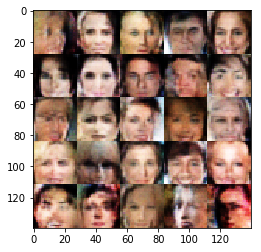

Epoch 0/1... Discriminator Loss: 2.0684... Generator Loss: 0.3111
Epoch 0/1... Discriminator Loss: 0.8654... Generator Loss: 1.0419
Epoch 0/1... Discriminator Loss: 0.3792... Generator Loss: 3.5882
Epoch 0/1... Discriminator Loss: 0.4955... Generator Loss: 5.2428
Epoch 0/1... Discriminator Loss: 0.4368... Generator Loss: 4.3197
Epoch 0/1... Discriminator Loss: 0.4162... Generator Loss: 3.9917
Epoch 0/1... Discriminator Loss: 0.4262... Generator Loss: 3.0374
Epoch 0/1... Discriminator Loss: 0.3486... Generator Loss: 4.8089
Epoch 0/1... Discriminator Loss: 0.4641... Generator Loss: 2.3423
Epoch 0/1... Discriminator Loss: 0.4834... Generator Loss: 2.1463


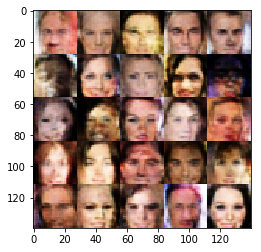

Epoch 0/1... Discriminator Loss: 0.3867... Generator Loss: 3.1894
Epoch 0/1... Discriminator Loss: 0.3514... Generator Loss: 4.5402
Epoch 0/1... Discriminator Loss: 0.3707... Generator Loss: 3.5580
Epoch 0/1... Discriminator Loss: 0.4636... Generator Loss: 2.6876
Epoch 0/1... Discriminator Loss: 0.3562... Generator Loss: 5.1137
Epoch 0/1... Discriminator Loss: 0.3823... Generator Loss: 3.2700
Epoch 0/1... Discriminator Loss: 0.3450... Generator Loss: 5.6036
Epoch 0/1... Discriminator Loss: 0.3658... Generator Loss: 3.7969
Epoch 0/1... Discriminator Loss: 0.4991... Generator Loss: 3.5733
Epoch 0/1... Discriminator Loss: 0.8504... Generator Loss: 5.4923


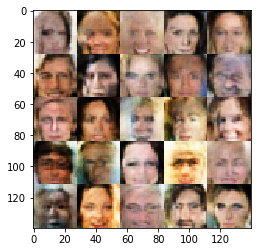

Epoch 0/1... Discriminator Loss: 0.5421... Generator Loss: 1.9524
Epoch 0/1... Discriminator Loss: 0.3888... Generator Loss: 3.3364
Epoch 0/1... Discriminator Loss: 0.4829... Generator Loss: 2.0816
Epoch 0/1... Discriminator Loss: 0.5032... Generator Loss: 3.1204
Epoch 0/1... Discriminator Loss: 0.5873... Generator Loss: 2.4726
Epoch 0/1... Discriminator Loss: 0.3726... Generator Loss: 3.3991
Epoch 0/1... Discriminator Loss: 0.3984... Generator Loss: 3.0967
Epoch 0/1... Discriminator Loss: 0.3664... Generator Loss: 4.1798
Epoch 0/1... Discriminator Loss: 0.5359... Generator Loss: 1.9702
Epoch 0/1... Discriminator Loss: 0.3557... Generator Loss: 5.8959


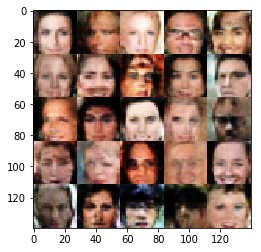

Epoch 0/1... Discriminator Loss: 0.3525... Generator Loss: 5.0386
Epoch 0/1... Discriminator Loss: 0.3402... Generator Loss: 6.0461
Epoch 0/1... Discriminator Loss: 0.4227... Generator Loss: 2.8490
Epoch 0/1... Discriminator Loss: 0.4294... Generator Loss: 2.5670
Epoch 0/1... Discriminator Loss: 0.9646... Generator Loss: 3.4597
Epoch 0/1... Discriminator Loss: 0.5842... Generator Loss: 1.9459
Epoch 0/1... Discriminator Loss: 0.3385... Generator Loss: 6.2485
Epoch 0/1... Discriminator Loss: 0.5939... Generator Loss: 1.7734
Epoch 0/1... Discriminator Loss: 2.1789... Generator Loss: 0.2481
Epoch 0/1... Discriminator Loss: 0.4019... Generator Loss: 3.1146


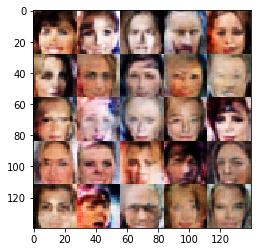

Epoch 0/1... Discriminator Loss: 0.3615... Generator Loss: 4.4488
Epoch 0/1... Discriminator Loss: 0.4177... Generator Loss: 3.0467
Epoch 0/1... Discriminator Loss: 0.3621... Generator Loss: 5.6390
Epoch 0/1... Discriminator Loss: 0.4518... Generator Loss: 2.4625
Epoch 0/1... Discriminator Loss: 0.5176... Generator Loss: 2.2243
Epoch 0/1... Discriminator Loss: 0.3798... Generator Loss: 3.5177
Epoch 0/1... Discriminator Loss: 0.4596... Generator Loss: 2.4022
Epoch 0/1... Discriminator Loss: 0.3546... Generator Loss: 4.8860
Epoch 0/1... Discriminator Loss: 0.3463... Generator Loss: 6.0419
Epoch 0/1... Discriminator Loss: 0.5431... Generator Loss: 1.8890


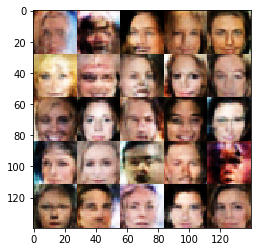

Epoch 0/1... Discriminator Loss: 0.3583... Generator Loss: 5.0663
Epoch 0/1... Discriminator Loss: 1.0833... Generator Loss: 0.9121
Epoch 0/1... Discriminator Loss: 0.4033... Generator Loss: 3.0347
Epoch 0/1... Discriminator Loss: 0.4034... Generator Loss: 5.5770
Epoch 0/1... Discriminator Loss: 0.5313... Generator Loss: 1.9240
Epoch 0/1... Discriminator Loss: 0.4813... Generator Loss: 2.5277
Epoch 0/1... Discriminator Loss: 0.3414... Generator Loss: 6.3060
Epoch 0/1... Discriminator Loss: 0.3484... Generator Loss: 4.8816
Epoch 0/1... Discriminator Loss: 0.3546... Generator Loss: 6.7557
Epoch 0/1... Discriminator Loss: 0.5369... Generator Loss: 3.7539


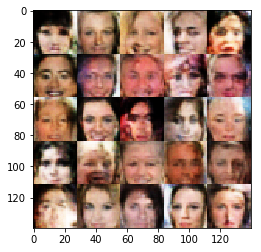

Epoch 0/1... Discriminator Loss: 0.3423... Generator Loss: 5.5540
Epoch 0/1... Discriminator Loss: 0.3427... Generator Loss: 4.6137
Epoch 0/1... Discriminator Loss: 0.3866... Generator Loss: 3.0905
Epoch 0/1... Discriminator Loss: 0.5924... Generator Loss: 1.7191
Epoch 0/1... Discriminator Loss: 0.3424... Generator Loss: 5.4234
Epoch 0/1... Discriminator Loss: 0.3432... Generator Loss: 5.3201
Epoch 0/1... Discriminator Loss: 0.3430... Generator Loss: 6.0539
Epoch 0/1... Discriminator Loss: 0.3397... Generator Loss: 7.6533
Epoch 0/1... Discriminator Loss: 0.4308... Generator Loss: 4.7323
Epoch 0/1... Discriminator Loss: 0.3486... Generator Loss: 5.7624


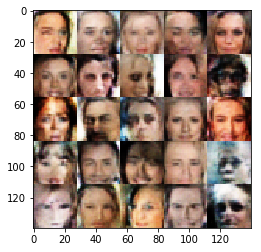

Epoch 0/1... Discriminator Loss: 0.3389... Generator Loss: 6.2237
Epoch 0/1... Discriminator Loss: 0.3354... Generator Loss: 7.7981
Epoch 0/1... Discriminator Loss: 0.3881... Generator Loss: 4.0370
Epoch 0/1... Discriminator Loss: 0.3637... Generator Loss: 4.1736
Epoch 0/1... Discriminator Loss: 2.1713... Generator Loss: 4.3583
Epoch 0/1... Discriminator Loss: 0.9925... Generator Loss: 0.8477
Epoch 0/1... Discriminator Loss: 0.4298... Generator Loss: 2.8038
Epoch 0/1... Discriminator Loss: 0.3626... Generator Loss: 4.1425
Epoch 0/1... Discriminator Loss: 0.4047... Generator Loss: 4.4949
Epoch 0/1... Discriminator Loss: 0.4161... Generator Loss: 2.9031


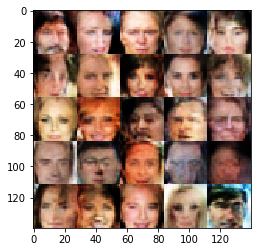

Epoch 0/1... Discriminator Loss: 0.3931... Generator Loss: 3.3777
Epoch 0/1... Discriminator Loss: 0.3508... Generator Loss: 4.6005
Epoch 0/1... Discriminator Loss: 0.3481... Generator Loss: 4.6428
Epoch 0/1... Discriminator Loss: 0.3816... Generator Loss: 3.5937
Epoch 0/1... Discriminator Loss: 0.4404... Generator Loss: 2.8535
Epoch 0/1... Discriminator Loss: 0.4270... Generator Loss: 2.6543
Epoch 0/1... Discriminator Loss: 0.3979... Generator Loss: 2.9642
Epoch 0/1... Discriminator Loss: 0.3942... Generator Loss: 3.4934
Epoch 0/1... Discriminator Loss: 1.1146... Generator Loss: 0.7720
Epoch 0/1... Discriminator Loss: 0.5808... Generator Loss: 1.6702


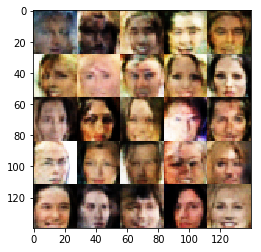

Epoch 0/1... Discriminator Loss: 0.3354... Generator Loss: 6.7019
Epoch 0/1... Discriminator Loss: 0.3423... Generator Loss: 5.1621
Epoch 0/1... Discriminator Loss: 0.3564... Generator Loss: 5.6330
Epoch 0/1... Discriminator Loss: 0.5509... Generator Loss: 1.7887
Epoch 0/1... Discriminator Loss: 0.7795... Generator Loss: 1.1478
Epoch 0/1... Discriminator Loss: 0.5416... Generator Loss: 2.4066
Epoch 0/1... Discriminator Loss: 0.8516... Generator Loss: 1.0504
Epoch 0/1... Discriminator Loss: 0.5025... Generator Loss: 2.1561
Epoch 0/1... Discriminator Loss: 0.9048... Generator Loss: 0.9707
Epoch 0/1... Discriminator Loss: 0.4690... Generator Loss: 2.4728


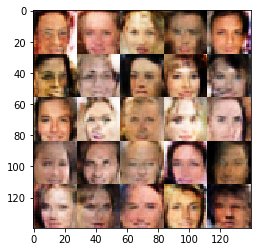

Epoch 0/1... Discriminator Loss: 0.6325... Generator Loss: 1.6386
Epoch 0/1... Discriminator Loss: 0.9411... Generator Loss: 0.9422
Epoch 0/1... Discriminator Loss: 0.6648... Generator Loss: 1.5857
Epoch 0/1... Discriminator Loss: 0.3765... Generator Loss: 8.9184
Epoch 0/1... Discriminator Loss: 0.3561... Generator Loss: 7.1398
Epoch 0/1... Discriminator Loss: 0.3965... Generator Loss: 5.8129
Epoch 0/1... Discriminator Loss: 0.3334... Generator Loss: 7.6448
Epoch 0/1... Discriminator Loss: 0.3645... Generator Loss: 4.0577
Epoch 0/1... Discriminator Loss: 0.8477... Generator Loss: 2.3635
Epoch 0/1... Discriminator Loss: 0.3710... Generator Loss: 3.7809


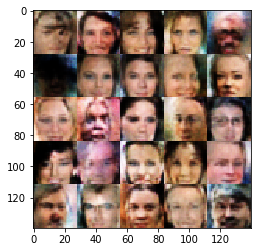

Epoch 0/1... Discriminator Loss: 0.4944... Generator Loss: 2.2773
Epoch 0/1... Discriminator Loss: 0.3554... Generator Loss: 5.5233
Epoch 0/1... Discriminator Loss: 0.3747... Generator Loss: 3.6772
Epoch 0/1... Discriminator Loss: 0.6012... Generator Loss: 1.8285
Epoch 0/1... Discriminator Loss: 0.3706... Generator Loss: 4.0458
Epoch 0/1... Discriminator Loss: 0.3461... Generator Loss: 6.4332
Epoch 0/1... Discriminator Loss: 0.4049... Generator Loss: 3.0647
Epoch 0/1... Discriminator Loss: 0.3989... Generator Loss: 3.1446
Epoch 0/1... Discriminator Loss: 0.4163... Generator Loss: 2.7324
Epoch 0/1... Discriminator Loss: 0.3457... Generator Loss: 5.1814


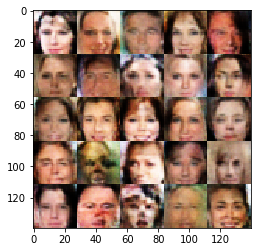

Epoch 0/1... Discriminator Loss: 0.3817... Generator Loss: 3.5723
Epoch 0/1... Discriminator Loss: 0.3605... Generator Loss: 6.1510
Epoch 0/1... Discriminator Loss: 0.3552... Generator Loss: 4.6636
Epoch 0/1... Discriminator Loss: 0.6106... Generator Loss: 4.4488
Epoch 0/1... Discriminator Loss: 0.3502... Generator Loss: 4.1827
Epoch 0/1... Discriminator Loss: 0.5617... Generator Loss: 6.9978
Epoch 0/1... Discriminator Loss: 0.3559... Generator Loss: 5.0768
Epoch 0/1... Discriminator Loss: 0.3473... Generator Loss: 4.9733
Epoch 0/1... Discriminator Loss: 0.3702... Generator Loss: 4.1572
Epoch 0/1... Discriminator Loss: 0.4348... Generator Loss: 6.3371


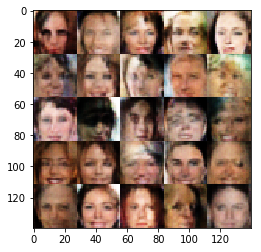

Epoch 0/1... Discriminator Loss: 0.3926... Generator Loss: 3.5057
Epoch 0/1... Discriminator Loss: 0.8823... Generator Loss: 1.0745
Epoch 0/1... Discriminator Loss: 2.7816... Generator Loss: 4.4762
Epoch 0/1... Discriminator Loss: 0.4592... Generator Loss: 2.4425
Epoch 0/1... Discriminator Loss: 0.3986... Generator Loss: 3.4568
Epoch 0/1... Discriminator Loss: 0.3793... Generator Loss: 3.9100
Epoch 0/1... Discriminator Loss: 0.6994... Generator Loss: 1.3118
Epoch 0/1... Discriminator Loss: 0.3566... Generator Loss: 5.3833
Epoch 0/1... Discriminator Loss: 0.3581... Generator Loss: 6.5003
Epoch 0/1... Discriminator Loss: 0.6129... Generator Loss: 1.6456


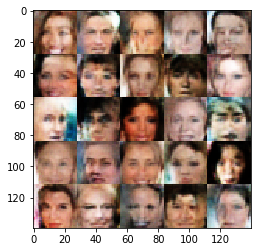

Epoch 0/1... Discriminator Loss: 0.4951... Generator Loss: 2.1236
Epoch 0/1... Discriminator Loss: 0.3447... Generator Loss: 5.1531
Epoch 0/1... Discriminator Loss: 0.3534... Generator Loss: 4.5155
Epoch 0/1... Discriminator Loss: 0.3642... Generator Loss: 4.1161
Epoch 0/1... Discriminator Loss: 0.3519... Generator Loss: 4.9269
Epoch 0/1... Discriminator Loss: 0.3454... Generator Loss: 5.2048
Epoch 0/1... Discriminator Loss: 0.3374... Generator Loss: 6.4437
Epoch 0/1... Discriminator Loss: 0.3872... Generator Loss: 5.4073
Epoch 0/1... Discriminator Loss: 0.3463... Generator Loss: 6.4215
Epoch 0/1... Discriminator Loss: 0.4000... Generator Loss: 3.8952


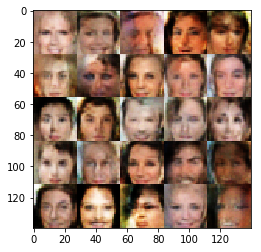

Epoch 0/1... Discriminator Loss: 0.3683... Generator Loss: 5.4105
Epoch 0/1... Discriminator Loss: 0.3514... Generator Loss: 4.7572
Epoch 0/1... Discriminator Loss: 0.3784... Generator Loss: 3.3857
Epoch 0/1... Discriminator Loss: 0.3367... Generator Loss: 8.3327
Epoch 0/1... Discriminator Loss: 0.3482... Generator Loss: 7.4196
Epoch 0/1... Discriminator Loss: 0.3853... Generator Loss: 3.4956
Epoch 0/1... Discriminator Loss: 0.3434... Generator Loss: 6.1117
Epoch 0/1... Discriminator Loss: 0.8000... Generator Loss: 1.1400
Epoch 0/1... Discriminator Loss: 2.7318... Generator Loss: 0.1784
Epoch 0/1... Discriminator Loss: 2.0544... Generator Loss: 0.3570


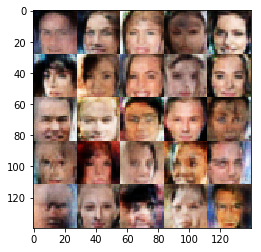

Epoch 0/1... Discriminator Loss: 1.0742... Generator Loss: 0.8130
Epoch 0/1... Discriminator Loss: 0.6715... Generator Loss: 1.6084
Epoch 0/1... Discriminator Loss: 0.7542... Generator Loss: 1.3304
Epoch 0/1... Discriminator Loss: 0.4038... Generator Loss: 3.0585
Epoch 0/1... Discriminator Loss: 0.4074... Generator Loss: 3.4263
Epoch 0/1... Discriminator Loss: 0.5679... Generator Loss: 1.8216
Epoch 0/1... Discriminator Loss: 0.5087... Generator Loss: 2.5841
Epoch 0/1... Discriminator Loss: 0.3757... Generator Loss: 3.5955
Epoch 0/1... Discriminator Loss: 0.3418... Generator Loss: 5.2249
Epoch 0/1... Discriminator Loss: 0.3589... Generator Loss: 4.5850


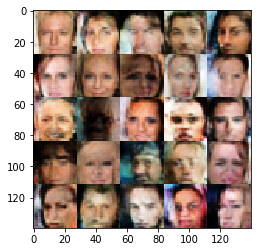

Epoch 0/1... Discriminator Loss: 0.9189... Generator Loss: 1.0244
Epoch 0/1... Discriminator Loss: 0.3630... Generator Loss: 6.1620
Epoch 0/1... Discriminator Loss: 0.4675... Generator Loss: 3.2171
Epoch 0/1... Discriminator Loss: 0.3773... Generator Loss: 3.7122
Epoch 0/1... Discriminator Loss: 0.3817... Generator Loss: 4.4987
Epoch 0/1... Discriminator Loss: 0.3559... Generator Loss: 4.7068
Epoch 0/1... Discriminator Loss: 0.4968... Generator Loss: 2.2109
Epoch 0/1... Discriminator Loss: 0.4348... Generator Loss: 2.5416
Epoch 0/1... Discriminator Loss: 0.4070... Generator Loss: 2.9604
Epoch 0/1... Discriminator Loss: 0.3835... Generator Loss: 4.1521


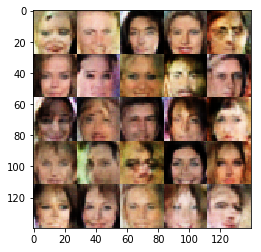

Epoch 0/1... Discriminator Loss: 0.3500... Generator Loss: 6.2565
Epoch 0/1... Discriminator Loss: 0.4014... Generator Loss: 3.1277
Epoch 0/1... Discriminator Loss: 0.4125... Generator Loss: 2.9650
Epoch 0/1... Discriminator Loss: 0.3654... Generator Loss: 4.0297
Epoch 0/1... Discriminator Loss: 0.3408... Generator Loss: 5.7524
Epoch 0/1... Discriminator Loss: 0.4276... Generator Loss: 2.8637
Epoch 0/1... Discriminator Loss: 0.4551... Generator Loss: 4.0298
Epoch 0/1... Discriminator Loss: 0.4381... Generator Loss: 2.4694
Epoch 0/1... Discriminator Loss: 0.3642... Generator Loss: 3.7310
Epoch 0/1... Discriminator Loss: 0.3557... Generator Loss: 5.6620


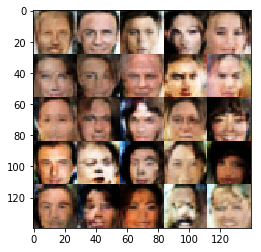

Epoch 0/1... Discriminator Loss: 0.3540... Generator Loss: 4.4838
Epoch 0/1... Discriminator Loss: 0.3408... Generator Loss: 6.4702
Epoch 0/1... Discriminator Loss: 1.3296... Generator Loss: 5.6361
Epoch 0/1... Discriminator Loss: 0.3674... Generator Loss: 4.0004
Epoch 0/1... Discriminator Loss: 0.5051... Generator Loss: 3.0998
Epoch 0/1... Discriminator Loss: 0.4790... Generator Loss: 2.1985
Epoch 0/1... Discriminator Loss: 0.4182... Generator Loss: 2.7584
Epoch 0/1... Discriminator Loss: 0.6320... Generator Loss: 1.6546
Epoch 0/1... Discriminator Loss: 0.3674... Generator Loss: 5.3816
Epoch 0/1... Discriminator Loss: 0.3431... Generator Loss: 5.5720


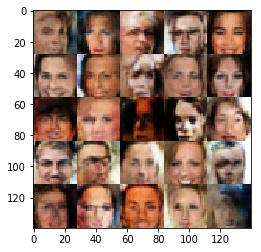

Epoch 0/1... Discriminator Loss: 0.3495... Generator Loss: 6.0175
Epoch 0/1... Discriminator Loss: 0.3636... Generator Loss: 3.8857
Epoch 0/1... Discriminator Loss: 0.3493... Generator Loss: 4.6342
Epoch 0/1... Discriminator Loss: 0.3591... Generator Loss: 4.6767
Epoch 0/1... Discriminator Loss: 0.3681... Generator Loss: 4.1969
Epoch 0/1... Discriminator Loss: 0.3482... Generator Loss: 5.4585
Epoch 0/1... Discriminator Loss: 0.3581... Generator Loss: 5.0150
Epoch 0/1... Discriminator Loss: 0.4029... Generator Loss: 3.7807
Epoch 0/1... Discriminator Loss: 0.3392... Generator Loss: 5.3161
Epoch 0/1... Discriminator Loss: 0.3760... Generator Loss: 4.2598


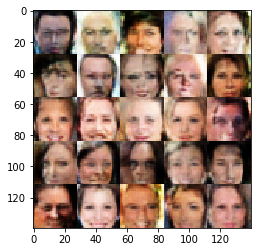

Epoch 0/1... Discriminator Loss: 0.3779... Generator Loss: 4.9629
Epoch 0/1... Discriminator Loss: 0.5105... Generator Loss: 3.4118
Epoch 0/1... Discriminator Loss: 2.9216... Generator Loss: 0.1548
Epoch 0/1... Discriminator Loss: 0.7485... Generator Loss: 1.6908
Epoch 0/1... Discriminator Loss: 0.4038... Generator Loss: 3.8592
Epoch 0/1... Discriminator Loss: 0.5276... Generator Loss: 2.6487
Epoch 0/1... Discriminator Loss: 0.4132... Generator Loss: 3.0173
Epoch 0/1... Discriminator Loss: 0.3828... Generator Loss: 3.7946
Epoch 0/1... Discriminator Loss: 0.5082... Generator Loss: 2.0399
Epoch 0/1... Discriminator Loss: 0.4079... Generator Loss: 2.9464


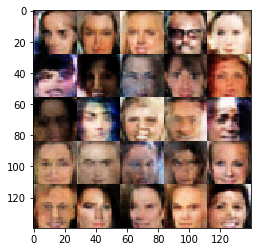

Epoch 0/1... Discriminator Loss: 0.6610... Generator Loss: 1.4573
Epoch 0/1... Discriminator Loss: 0.5607... Generator Loss: 1.8007
Epoch 0/1... Discriminator Loss: 0.4048... Generator Loss: 3.1622
Epoch 0/1... Discriminator Loss: 0.4391... Generator Loss: 2.7183
Epoch 0/1... Discriminator Loss: 0.3787... Generator Loss: 3.6392
Epoch 0/1... Discriminator Loss: 0.4602... Generator Loss: 2.3071
Epoch 0/1... Discriminator Loss: 0.4148... Generator Loss: 7.2743
Epoch 0/1... Discriminator Loss: 0.4229... Generator Loss: 3.2393
Epoch 0/1... Discriminator Loss: 0.4477... Generator Loss: 3.7383
Epoch 0/1... Discriminator Loss: 0.4309... Generator Loss: 3.2969


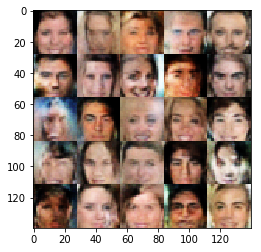

Epoch 0/1... Discriminator Loss: 0.3642... Generator Loss: 4.6238
Epoch 0/1... Discriminator Loss: 0.3821... Generator Loss: 6.3532
Epoch 0/1... Discriminator Loss: 0.4208... Generator Loss: 2.9537
Epoch 0/1... Discriminator Loss: 0.9358... Generator Loss: 0.9289
Epoch 0/1... Discriminator Loss: 0.5934... Generator Loss: 1.7649
Epoch 0/1... Discriminator Loss: 0.3705... Generator Loss: 3.9888
Epoch 0/1... Discriminator Loss: 0.7967... Generator Loss: 1.3684
Epoch 0/1... Discriminator Loss: 1.6447... Generator Loss: 0.4484
Epoch 0/1... Discriminator Loss: 0.8088... Generator Loss: 1.1373
Epoch 0/1... Discriminator Loss: 0.6319... Generator Loss: 1.5964


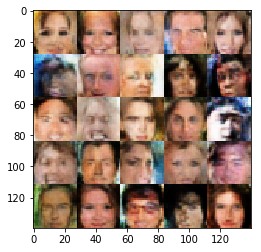

Epoch 0/1... Discriminator Loss: 0.3759... Generator Loss: 3.6492
Epoch 0/1... Discriminator Loss: 0.4180... Generator Loss: 2.9592
Epoch 0/1... Discriminator Loss: 0.3755... Generator Loss: 5.5302
Epoch 0/1... Discriminator Loss: 0.3489... Generator Loss: 6.3005
Epoch 0/1... Discriminator Loss: 0.5177... Generator Loss: 2.0034
Epoch 0/1... Discriminator Loss: 0.8255... Generator Loss: 3.0418
Epoch 0/1... Discriminator Loss: 0.4113... Generator Loss: 2.9191
Epoch 0/1... Discriminator Loss: 0.3869... Generator Loss: 3.8587
Epoch 0/1... Discriminator Loss: 0.4096... Generator Loss: 3.6207
Epoch 0/1... Discriminator Loss: 0.4747... Generator Loss: 3.0869


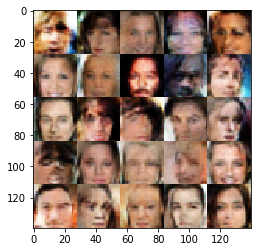

Epoch 0/1... Discriminator Loss: 0.3567... Generator Loss: 4.3024
Epoch 0/1... Discriminator Loss: 0.3400... Generator Loss: 7.0615
Epoch 0/1... Discriminator Loss: 0.5936... Generator Loss: 1.6357
Epoch 0/1... Discriminator Loss: 0.3561... Generator Loss: 4.0897
Epoch 0/1... Discriminator Loss: 0.4391... Generator Loss: 4.1652
Epoch 0/1... Discriminator Loss: 0.3580... Generator Loss: 4.0618
Epoch 0/1... Discriminator Loss: 0.3475... Generator Loss: 4.7781
Epoch 0/1... Discriminator Loss: 0.4337... Generator Loss: 3.1466
Epoch 0/1... Discriminator Loss: 0.5367... Generator Loss: 1.7585
Epoch 0/1... Discriminator Loss: 0.3598... Generator Loss: 4.2956


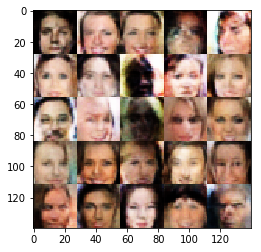

Epoch 0/1... Discriminator Loss: 0.4396... Generator Loss: 2.5743
Epoch 0/1... Discriminator Loss: 0.3670... Generator Loss: 4.7481
Epoch 0/1... Discriminator Loss: 0.3479... Generator Loss: 7.5044


In [20]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.